# NLP Disaster Tweets
### Problem: 
In this kaggle competition, [Natural Language Processing with IDsaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started), the problem is to detect a disaster in Tweets. Spefically, I need to build a ML pipeline to predict whether the text in a tweet represents a real disaster or not. This problem genre is a large area of interest in the Natural Language Processing (NLP) field due to the the struggle to teach a machine contextual reasoning. For example, a tweet may contain keywords like "fire"" or "disaster" while not portraying an actual disaster scenario. As humans, we can usually make out the difference between a real disaster or not quite easily and quickly, but teaching a computer to do so is trickier. The challenge remains to build robust NLP models that can accurately learn the nuances of human language and text to predict disasters. 

### Dataset:
The dataset for this project is 1.43 MB in size and contains 10,000 tweets that were hand labeled as disaster or non-disaster, with 1 indcating a disaster and 0 non-disaster. There are 3 csv files in the dataset, sample_submission, test, and train. The sample submission, which is 22.75 kB, contains an outline of how submission files should be structured. The train file, which is 987.71 kB, contains 7,613 unique ids, and 3 feature columns. The features include keyword, location, and text. The last column is the hand labeled target: 0 or 1. The test file, which is 420.78 kB, contains 3,263 unique ids with the same 3 features: keyword, location, and text. This file does not contain the label as it is the test set that predictions will be performed on. 
### Libraries

In [ ]:
!pip install ace-tools-open
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.4 MB/s eta 0:00:00


In [ ]:
# utilities
import os
import re
import gc
import string
import contractions
from urllib.parse import urlparse
from collections import defaultdict

# data handling
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS

# NLP preprocessing
import nltk
from nltk.corpus import stopwords
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Sklearn (FE, model eval, ML models)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.metrics import (f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay)

# deel learning and transformers
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset as TorchDataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, DebertaV2Tokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding)

# GloVe embeddings (via Gensim)
import gensim.downloader as api

# hyperparameter optimization
import optuna


# Exploratroy Data Analysis

In this section, I go about examining the data, looking for patterns that could give me clues on how to clean the data and how to setup my model architecture. 

In [ ]:
# local dataset paths
DATA_PATH = "data/"
# load the datasets 
df_train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"), dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv(os.path.join(DATA_PATH, "test.csv"), dtype={'id': np.int16})
df_sample_submission = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))

# quick check on dtypes and memory usage
print(df_train.info(memory_usage='deep'))
print(df_test.info(memory_usage='deep'))

# display the first few rows
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 2.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int16 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int16(1), object(3)
memory usage: 914.8 KB
None


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


I instantly notice that there are many NaN values in keyword and location, so I inspect the number and percent of missing values in each feature for both the training and testing data.

In [ ]:
missing_ids = df_train['id'].isna().sum()
missing_keyword = df_train['keyword'].isna().sum()
missing_location = df_train['location'].isna().sum()
missing_text = df_train['text'].isna().sum()

print(f"Missing Training IDs: {missing_ids}")
print(f"Missing Training Keywords: {missing_keyword}")
print(f"Missing Training Locations: {missing_location}")
print(f"Missing Training Text: {missing_text}")

percentage_missing = (df_train.isna().sum() / len(df_train)) * 100
print(f"Missing Training Percent: {percentage_missing}")

Missing Training IDs: 0
Missing Training Keywords: 61
Missing Training Locations: 2533
Missing Training Text: 0
Missing Training Percent: id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


In [ ]:
missing_ids = df_test['id'].isna().sum()
missing_keyword = df_test['keyword'].isna().sum()
missing_location = df_test['location'].isna().sum()
missing_text = df_test['text'].isna().sum()

print(f"Missing Testing IDs: {missing_ids}")
print(f"Missing Testing Keywords: {missing_keyword}")
print(f"Missing Testing Locations: {missing_location}")
print(f"Missing Testing Text: {missing_text}")

percentage_missing = (df_test.isna().sum() / len(df_train)) * 100
print(f"Missing Testing Percent: {percentage_missing}")

Missing Testing IDs: 0
Missing Testing Keywords: 26
Missing Testing Locations: 1105
Missing Testing Text: 0
Missing Testing Percent: id           0.000000
keyword      0.341521
location    14.514646
text         0.000000
dtype: float64


I notice there are many tweets in the training data missing location (33.27%) and a few missing keywords (.80%), cluing me into the need to handle location carefully. The testing data does not have as many missing values, but it similarly has many missing locations (14.51%) and a few missing keywords (.34%). I will need to consider dropping the rows with missing keywords or locations or possible imputation strategies. 

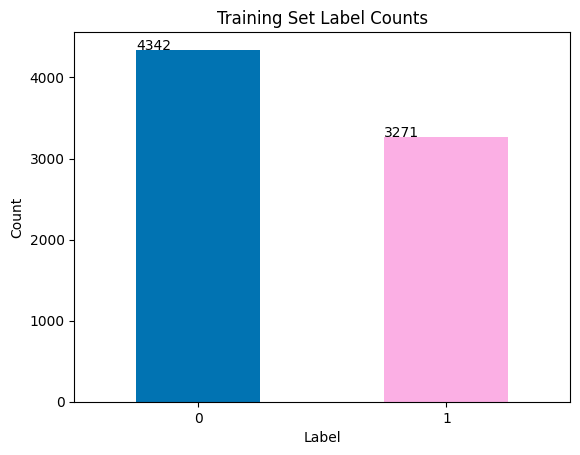

In [ ]:
# look at the label stats
target_counts = df_train['target'].value_counts()

# make the bar plot
palette = sns.color_palette("colorblind")
target_counts.plot(kind='bar', color=[palette[0], palette[6]]) 
plt.title("Training Set Label Counts")
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], rotation=0) 
for p in plt.gca().patches: 
    plt.annotate(str(p.get_height()), (p.get_x(), p.get_height()))
plt.show()

Looking at the label counts provides me with knowledge on the class balance. 57.03% of the tweets contain non-disaster tweets, while 42.97% contain disasters. This is not terribly unbalanced. But upsampling of disaster tweets could possibly improve model performance.

Here I add columns for the number of characters in the text column and number of words in the text column for both the training and test set. Then I plot the distribution to get a sense of the average tweet length and word count. 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


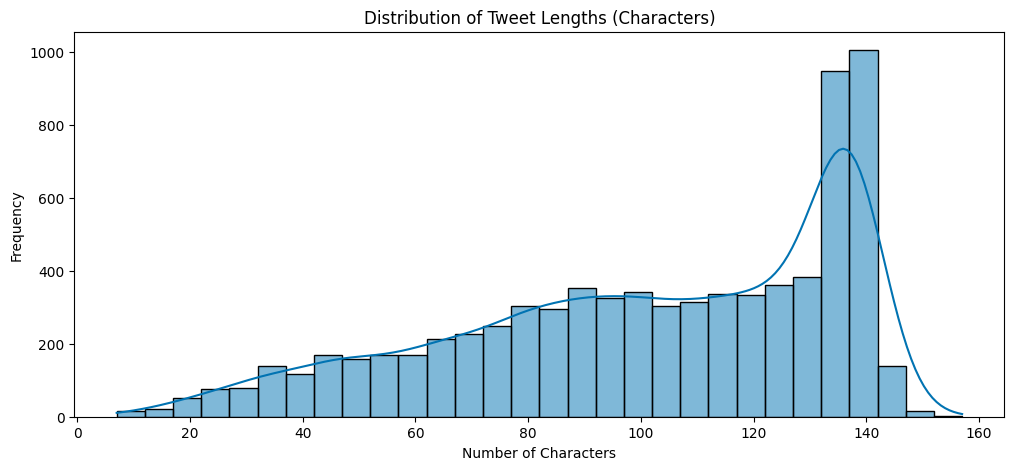

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


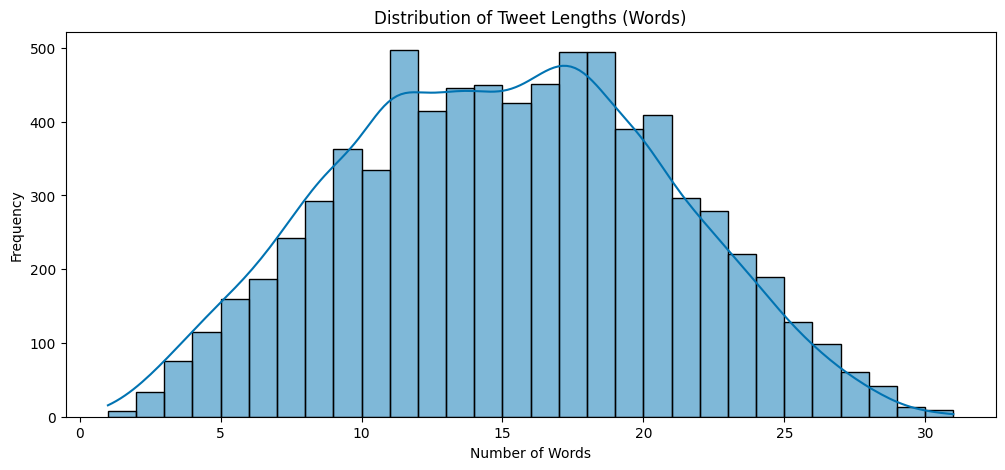

In [ ]:
# add cols for text length in characters and words
df_train['text_length_char'] = df_train['text'].apply(len)
df_train['text_length_word'] = df_train['text'].apply(lambda x: len(x.split()))

df_test['text_length_char'] = df_test['text'].apply(len)
df_test['text_length_word'] = df_test['text'].apply(lambda x: len(x.split()))

# plot distribution of tweet lengths (characters)
plt.figure(figsize=(12, 5))
sns.histplot(df_train['text_length_char'], bins=30, kde=True, color=palette[0])
plt.title('Distribution of Tweet Lengths (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# plot distribution of tweet lengths (words)
plt.figure(figsize=(12, 5))
sns.histplot(df_train['text_length_word'], bins=30, kde=True, color=palette[0])
plt.title('Distribution of Tweet Lengths (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

I see that the number of characters in tweets is skewed rightward toward around 138 characters, which makes sense since tweet lengths are limited to 140 characters. I am interested to inspect ones with >140 characters as I though 140 was the maximum. The number of words is more normally distributed with around 10-20 words being the most common.

In [ ]:
# statistics for text length
print("Character Length Stats:\n", df_train['text_length_char'].describe())
print("\nWord Length Stats:\n", df_train['text_length_word'].describe())

Character Length Stats:
 count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length_char, dtype: float64

Word Length Stats:
 count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: text_length_word, dtype: float64


In [ ]:
# tweets with >140 characters
long_tweets_df = df_train[df_train['text_length_char'] > 140][['text']]

# display all text
pd.set_option('display.max_colwidth', None) # full text is shown

for idx, tweet in enumerate(long_tweets_df['text'].head(1), 1):
    print(f"{idx}: {tweet}")

1: mom: 'we didn't get home as fast as we wished' 
me: 'why is that?'
mom: 'there was an accident and some truck spilt mayonnaise all over ??????


This tweet contains 143 characters, so there must be tweets from after 2017 when Twitter increased the maximum character count to 280. 

Number of unique keywords: 221


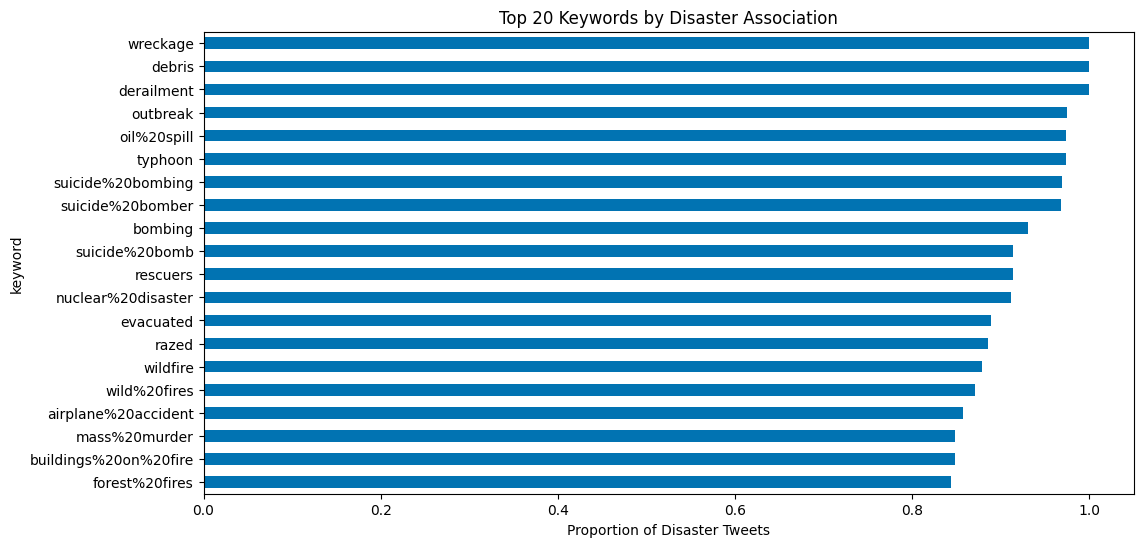

In [ ]:
# check how many unique keywords
unique_keywords = df_train['keyword'].nunique()
print(f"Number of unique keywords: {unique_keywords}")

# how keywords correlate w disaster tweets
keyword_disaster_ratio = df_train.groupby('keyword')['target'].mean().sort_values(ascending=False)

# visualize top keywords most associated w disasters
plt.figure(figsize=(12, 6))
keyword_disaster_ratio.head(20).plot(kind='barh', color=palette[0])
plt.gca().invert_yaxis()
plt.title('Top 20 Keywords by Disaster Association')
plt.xlabel('Proportion of Disaster Tweets')
plt.show()

From the bar plot of keywords that have the greatest ratio of correlating with a diaster I can see that debris, wreckage, and derailment have the largest percentage. 

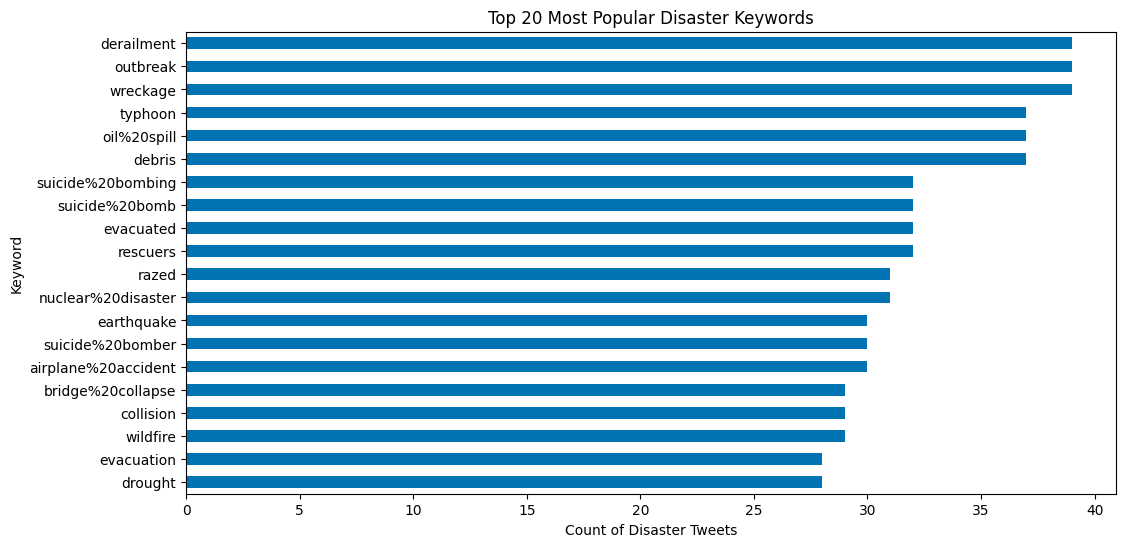

In [ ]:
keyword_disaster_counts = df_train[df_train['target'] == 1]['keyword'].value_counts()
top_keywords = keyword_disaster_counts.head(20)

plt.figure(figsize=(12, 6))
top_keywords.plot(kind='barh', color=palette[0])
plt.gca().invert_yaxis()
plt.title('Top 20 Most Popular Disaster Keywords')
plt.xlabel('Count of Disaster Tweets')
plt.ylabel('Keyword')
plt.show()

The top 3 keywords by count are the same.

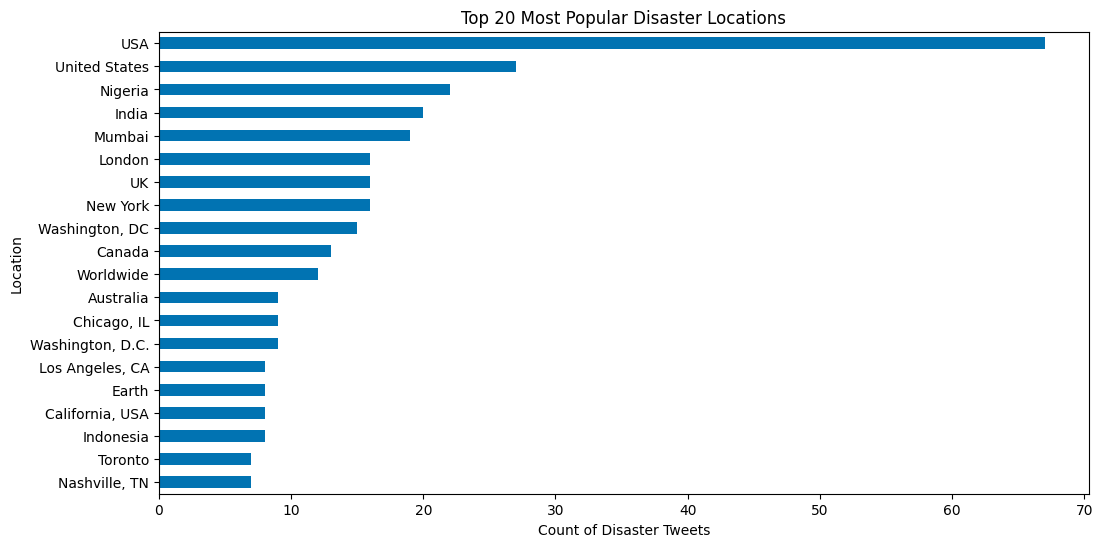

In [ ]:
location_disaster_counts = df_train[df_train['target'] == 1]['location'].value_counts()
top_keywords = location_disaster_counts.head(20)

plt.figure(figsize=(12, 6))
top_keywords.plot(kind='barh', color=palette[0])
plt.gca().invert_yaxis()
plt.title('Top 20 Most Popular Disaster Locations')
plt.xlabel('Count of Disaster Tweets')
plt.ylabel('Location')
plt.show()

                 total_count  disaster_ratio
location                                    
USA                      104        0.644231
New York                  71        0.225352
United States             50        0.540000
London                    45        0.355556
Canada                    29        0.448276
Nigeria                   28        0.785714
UK                        27        0.592593
Los Angeles, CA           26        0.307692
India                     24        0.833333
Mumbai                    22        0.863636


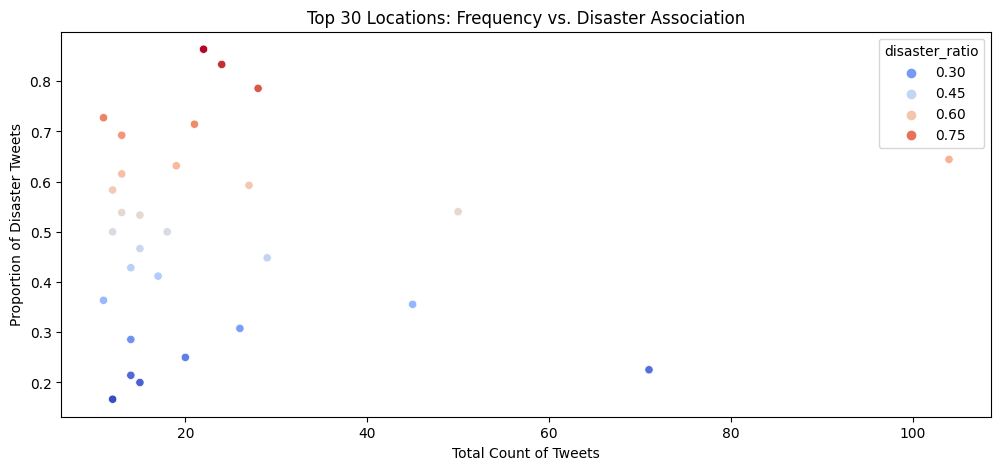

In [ ]:
# group by location to get both counts and disaster ratios
location_stats = df_train.groupby('location').agg(total_count=('target', 'count'), disaster_ratio=('target', 'mean')).sort_values(by='total_count', ascending=False)

# top 10 most frequent locations w their disaster relevance
print(location_stats.head(10))

# visualizing the top locations by frequency and disaster relevance
plt.figure(figsize=(12, 5))
sns.scatterplot(data=location_stats.head(30), x='total_count', y='disaster_ratio', hue='disaster_ratio', palette='coolwarm')
plt.title('Top 30 Locations: Frequency vs. Disaster Association')
plt.xlabel('Total Count of Tweets')
plt.ylabel('Proportion of Disaster Tweets')
plt.show()

Most disasters occur in the USA, with a count of 104. This makes sense as Twitter is US based. Highest proportion of disaster tweets by location is Mumbai, India, and Nigeria. 

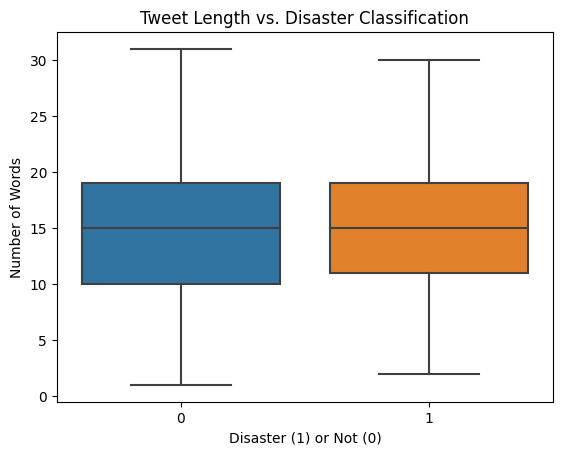

In [ ]:
# check correlation between tweet length and disaster likelihood
sns.boxplot(x=df_train['target'], y=df_train['text_length_word'])
plt.title('Tweet Length vs. Disaster Classification')
plt.xlabel('Disaster (1) or Not (0)')
plt.ylabel('Number of Words')
plt.show()

No clear correlation.

Next, I make unigrams, bigrams, and trigrams to show the top 10 most common uni/bi/trigrams in disaster and non disaster tweets. The code for these ngrams was modified from Gunes Evitan and found in their [public kernel](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert).

In [ ]:
disaster_label = df_train['target'] == 1

def make_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

num_ngrams = 5

# unigrams
unigrams_for_disasters = defaultdict(int)
unigrams_for_non_disasters= defaultdict(int)

for text in df_train[disaster_label]['text']:
    for w in make_ngrams(text):
        unigrams_for_disasters[w] += 1
        
for text in df_train[~disaster_label]['text']:
    for w in make_ngrams(text):
        unigrams_for_non_disasters[w] += 1
        
df_disaster_uni = pd.DataFrame(sorted(unigrams_for_disasters.items(), key=lambda x: x[1])[::-1])
df_non_disaster_uni = pd.DataFrame(sorted(unigrams_for_non_disasters.items(), key=lambda x: x[1])[::-1])

# bigrams
bigrams_for_disasters = defaultdict(int)
bigrams_for_non_disasters = defaultdict(int)

for text in df_train[disaster_label]['text']:
    for w in make_ngrams(text, n_gram=2):
        bigrams_for_disasters[w] += 1
        
for text in df_train[~disaster_label]['text']:
    for w in make_ngrams(text, n_gram=2):
        bigrams_for_non_disasters[w] += 1
        
df_disaster_bi = pd.DataFrame(sorted(bigrams_for_disasters.items(), key=lambda x: x[1])[::-1])
df_not_disaster_bi = pd.DataFrame(sorted(bigrams_for_non_disasters.items(), key=lambda x: x[1])[::-1])

# trigrams
trigrams_for_disasters = defaultdict(int)
trigrams_for_non_disasters = defaultdict(int)

for text in df_train[disaster_label]['text']:
    for w in make_ngrams(text, n_gram=3):
        trigrams_for_disasters[w] += 1
        
for text in df_train[~disaster_label]['text']:
    for w in make_ngrams(text, n_gram=3):
        trigrams_for_non_disasters[w] += 1
        
df_disaster_tri = pd.DataFrame(sorted(trigrams_for_disasters.items(), key=lambda x: x[1])[::-1])
df_non_disaster_tri = pd.DataFrame(sorted(trigrams_for_non_disasters.items(), key=lambda x: x[1])[::-1])

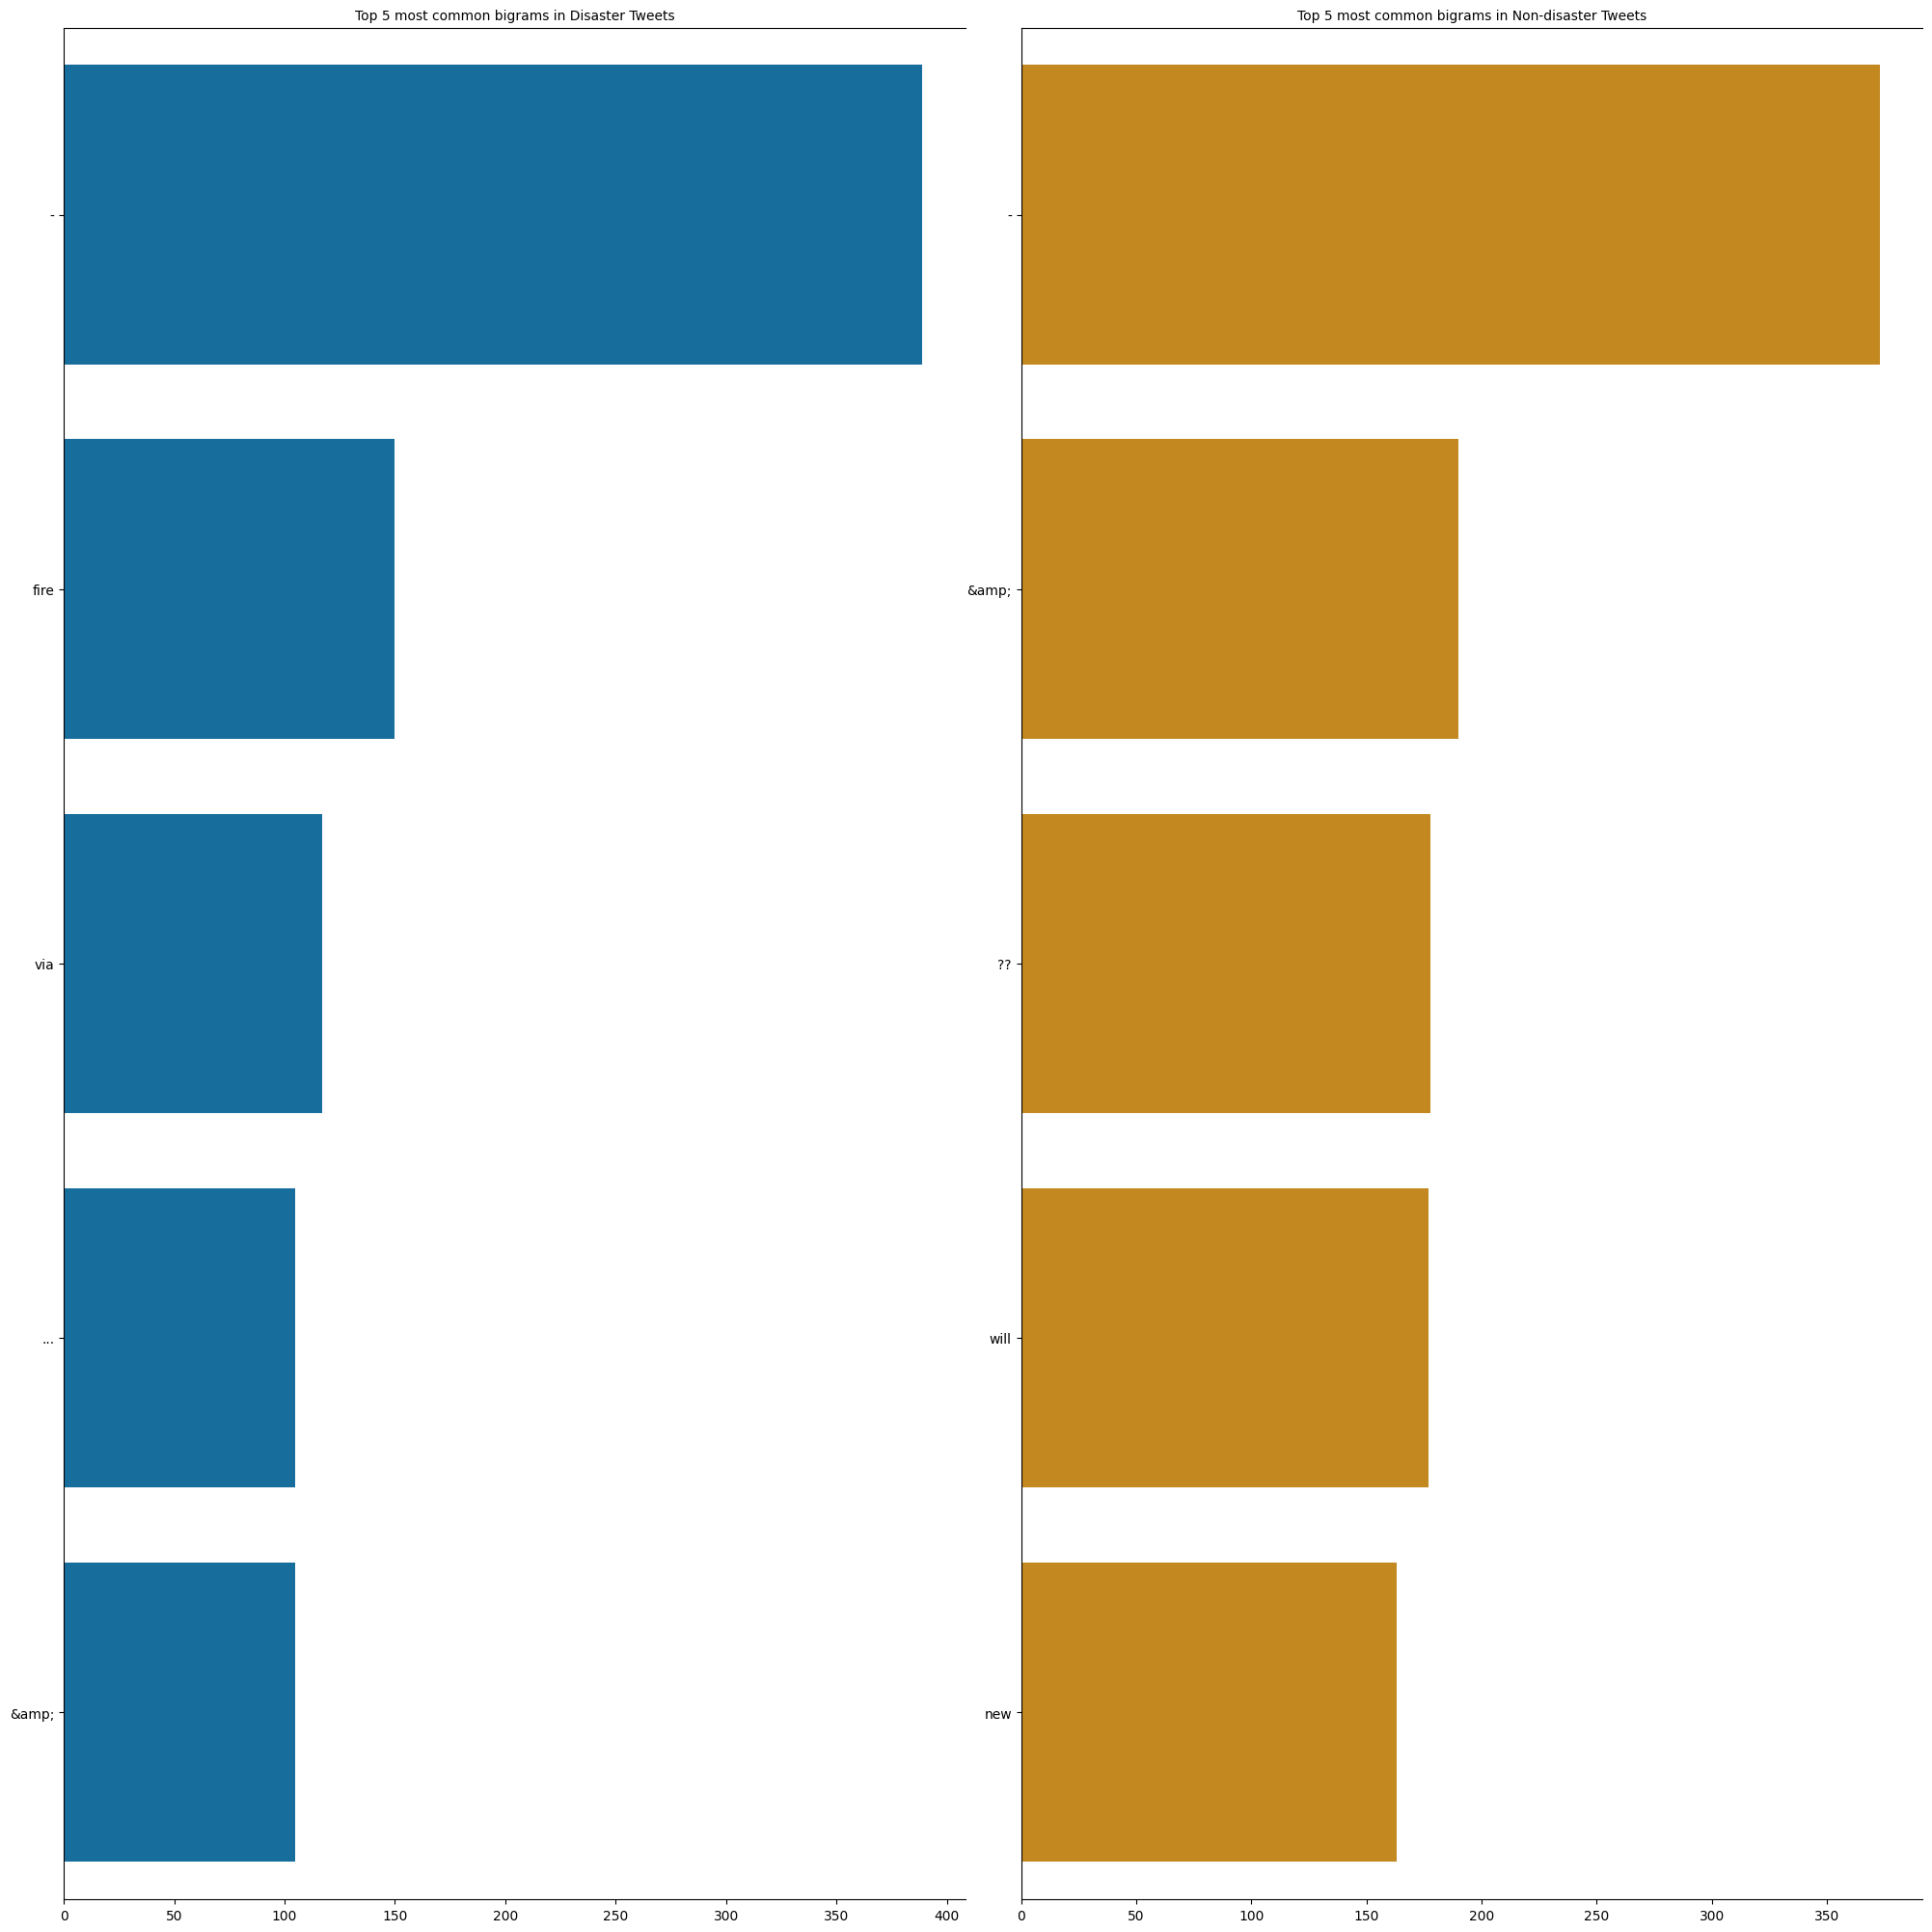

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 20), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_uni[0].values[:num_ngrams], x=df_disaster_uni[1].values[:num_ngrams], ax=axes[0], color=palette[0])
sns.barplot(y=df_non_disaster_uni[0].values[:num_ngrams], x=df_non_disaster_uni[1].values[:num_ngrams], ax=axes[1], color=palette[1])

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

axes[0].set_title(f'Top {num_ngrams} most common bigrams in Disaster Tweets', fontsize=10)
axes[1].set_title(f'Top {num_ngrams} most common bigrams in Non-disaster Tweets', fontsize=10)
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


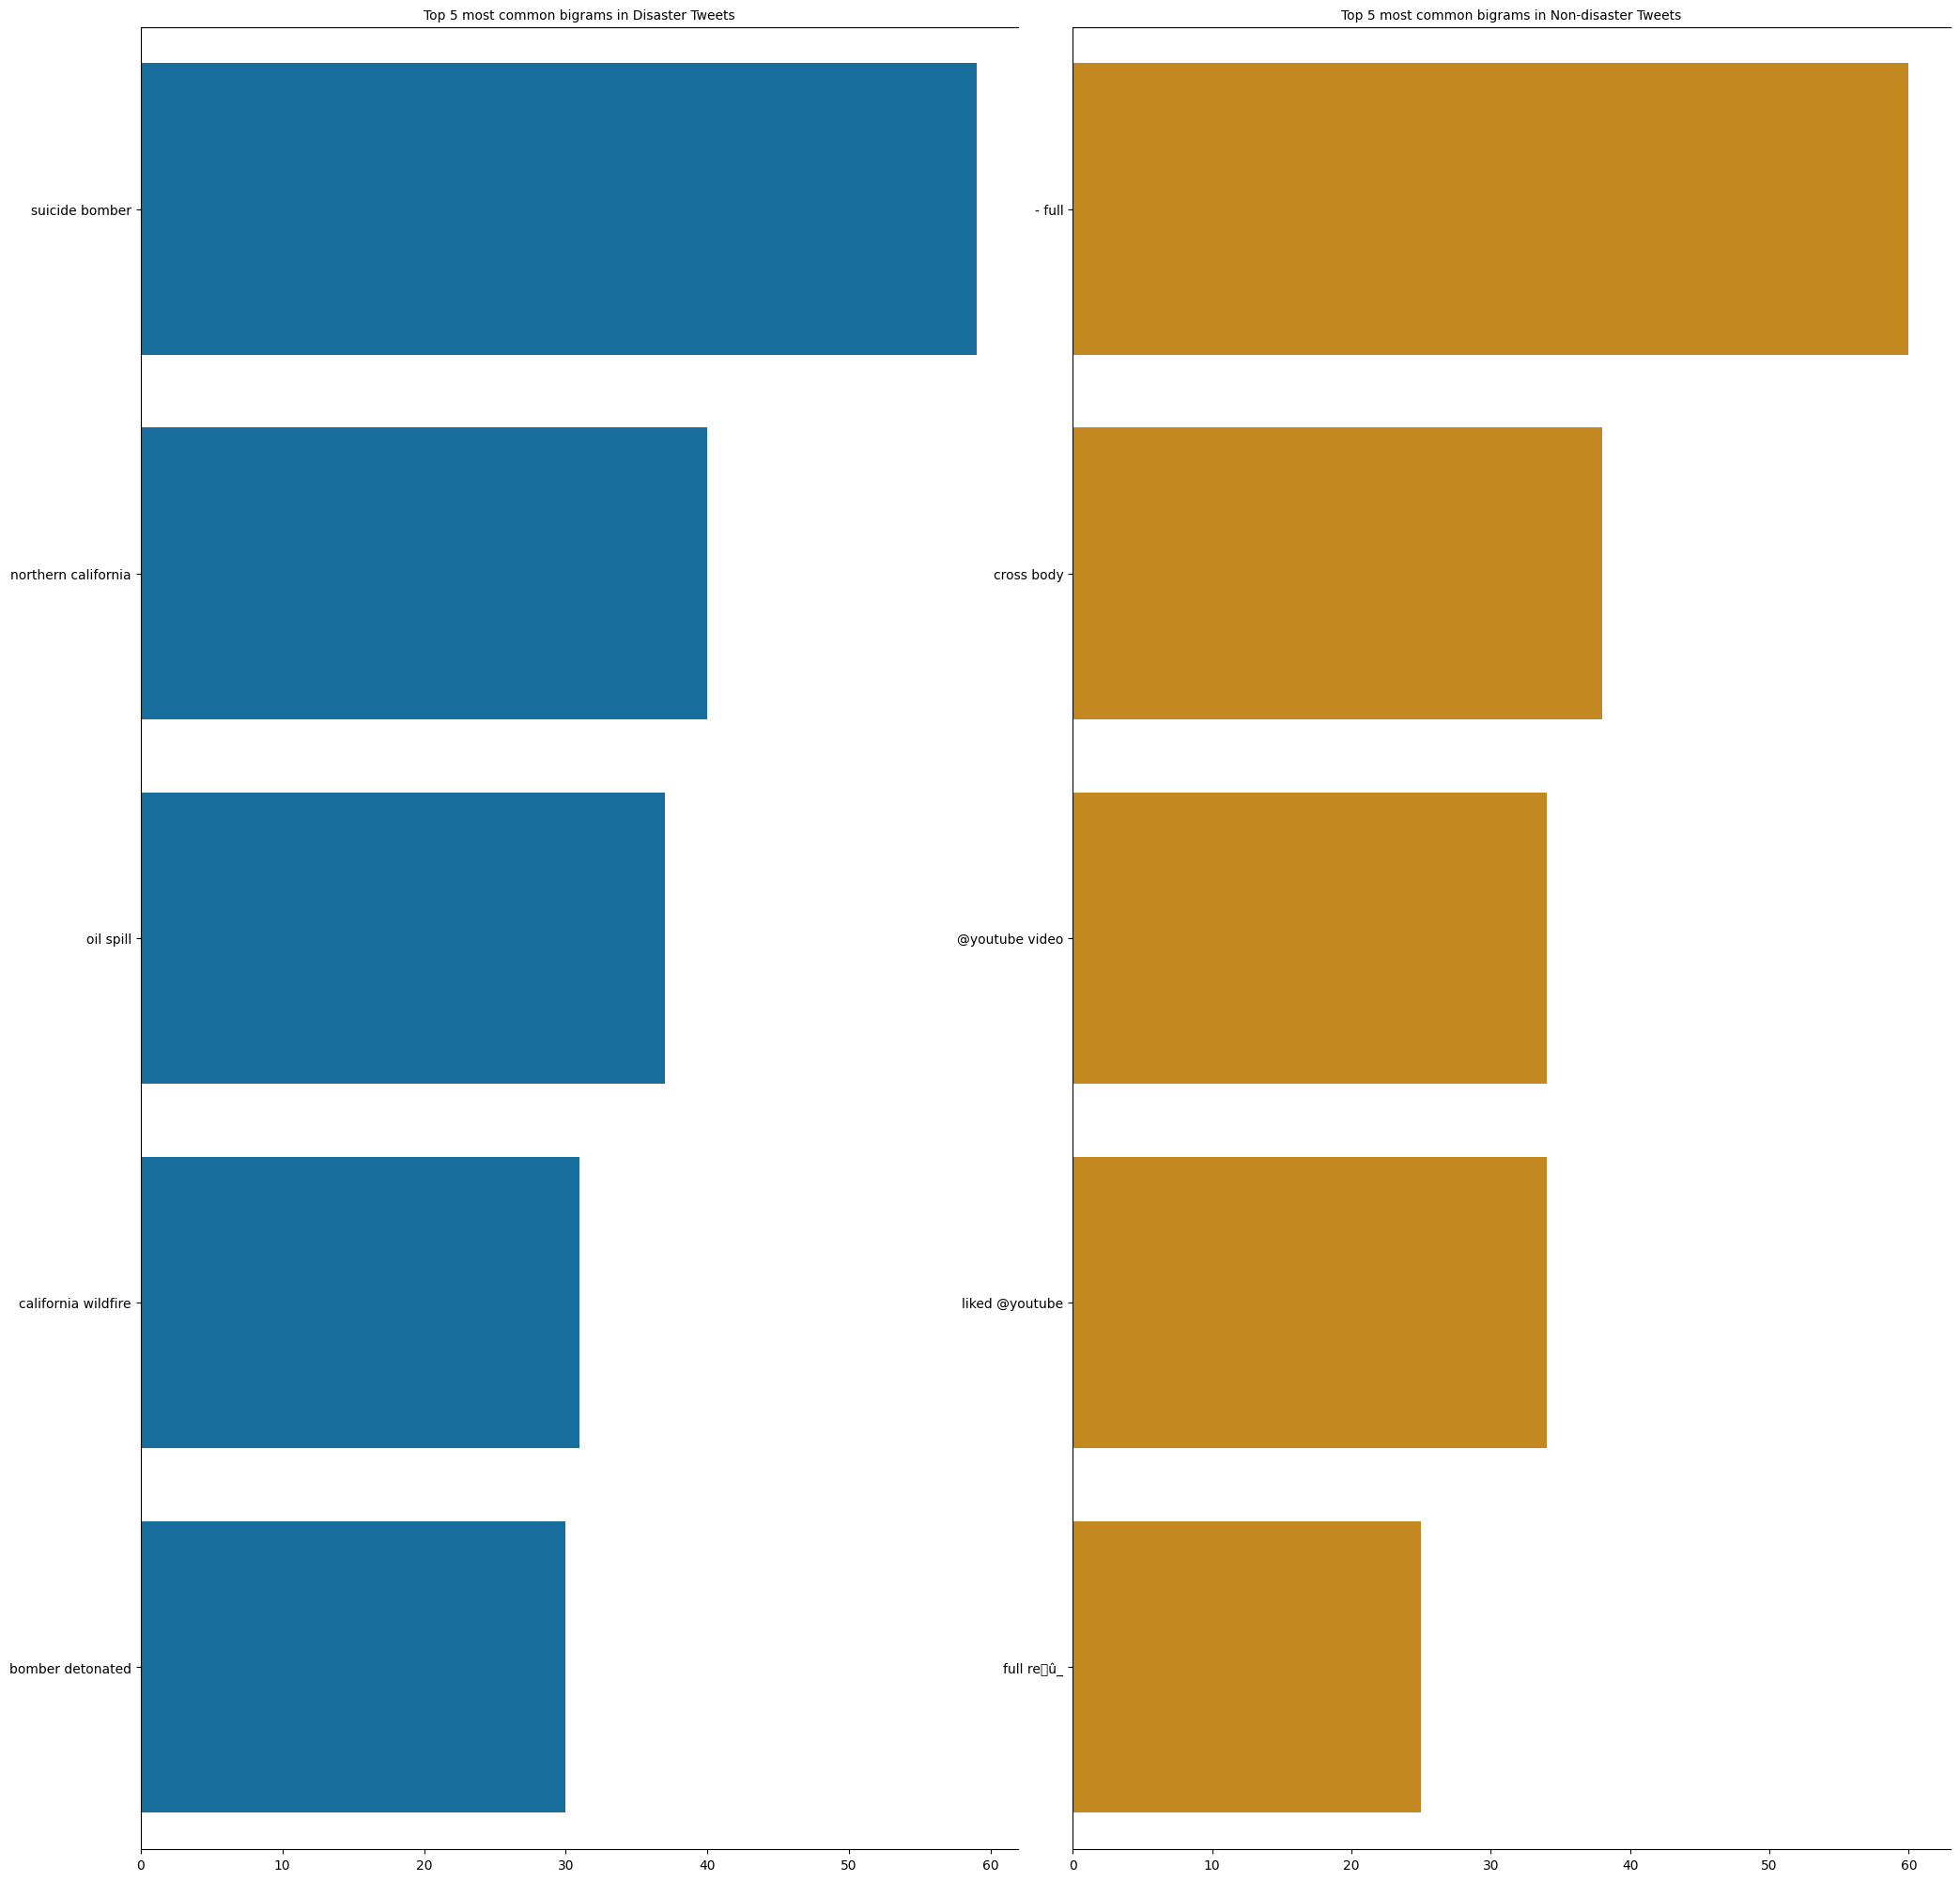

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 20), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bi[0].values[:num_ngrams], x=df_disaster_bi[1].values[:num_ngrams], ax=axes[0], color=palette[0])
sns.barplot(y=df_not_disaster_bi[0].values[:num_ngrams], x=df_not_disaster_bi[1].values[:num_ngrams], ax=axes[1], color=palette[1])

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

axes[0].set_title(f'Top {num_ngrams} most common bigrams in Disaster Tweets', fontsize=10)
axes[1].set_title(f'Top {num_ngrams} most common bigrams in Non-disaster Tweets', fontsize=10)
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


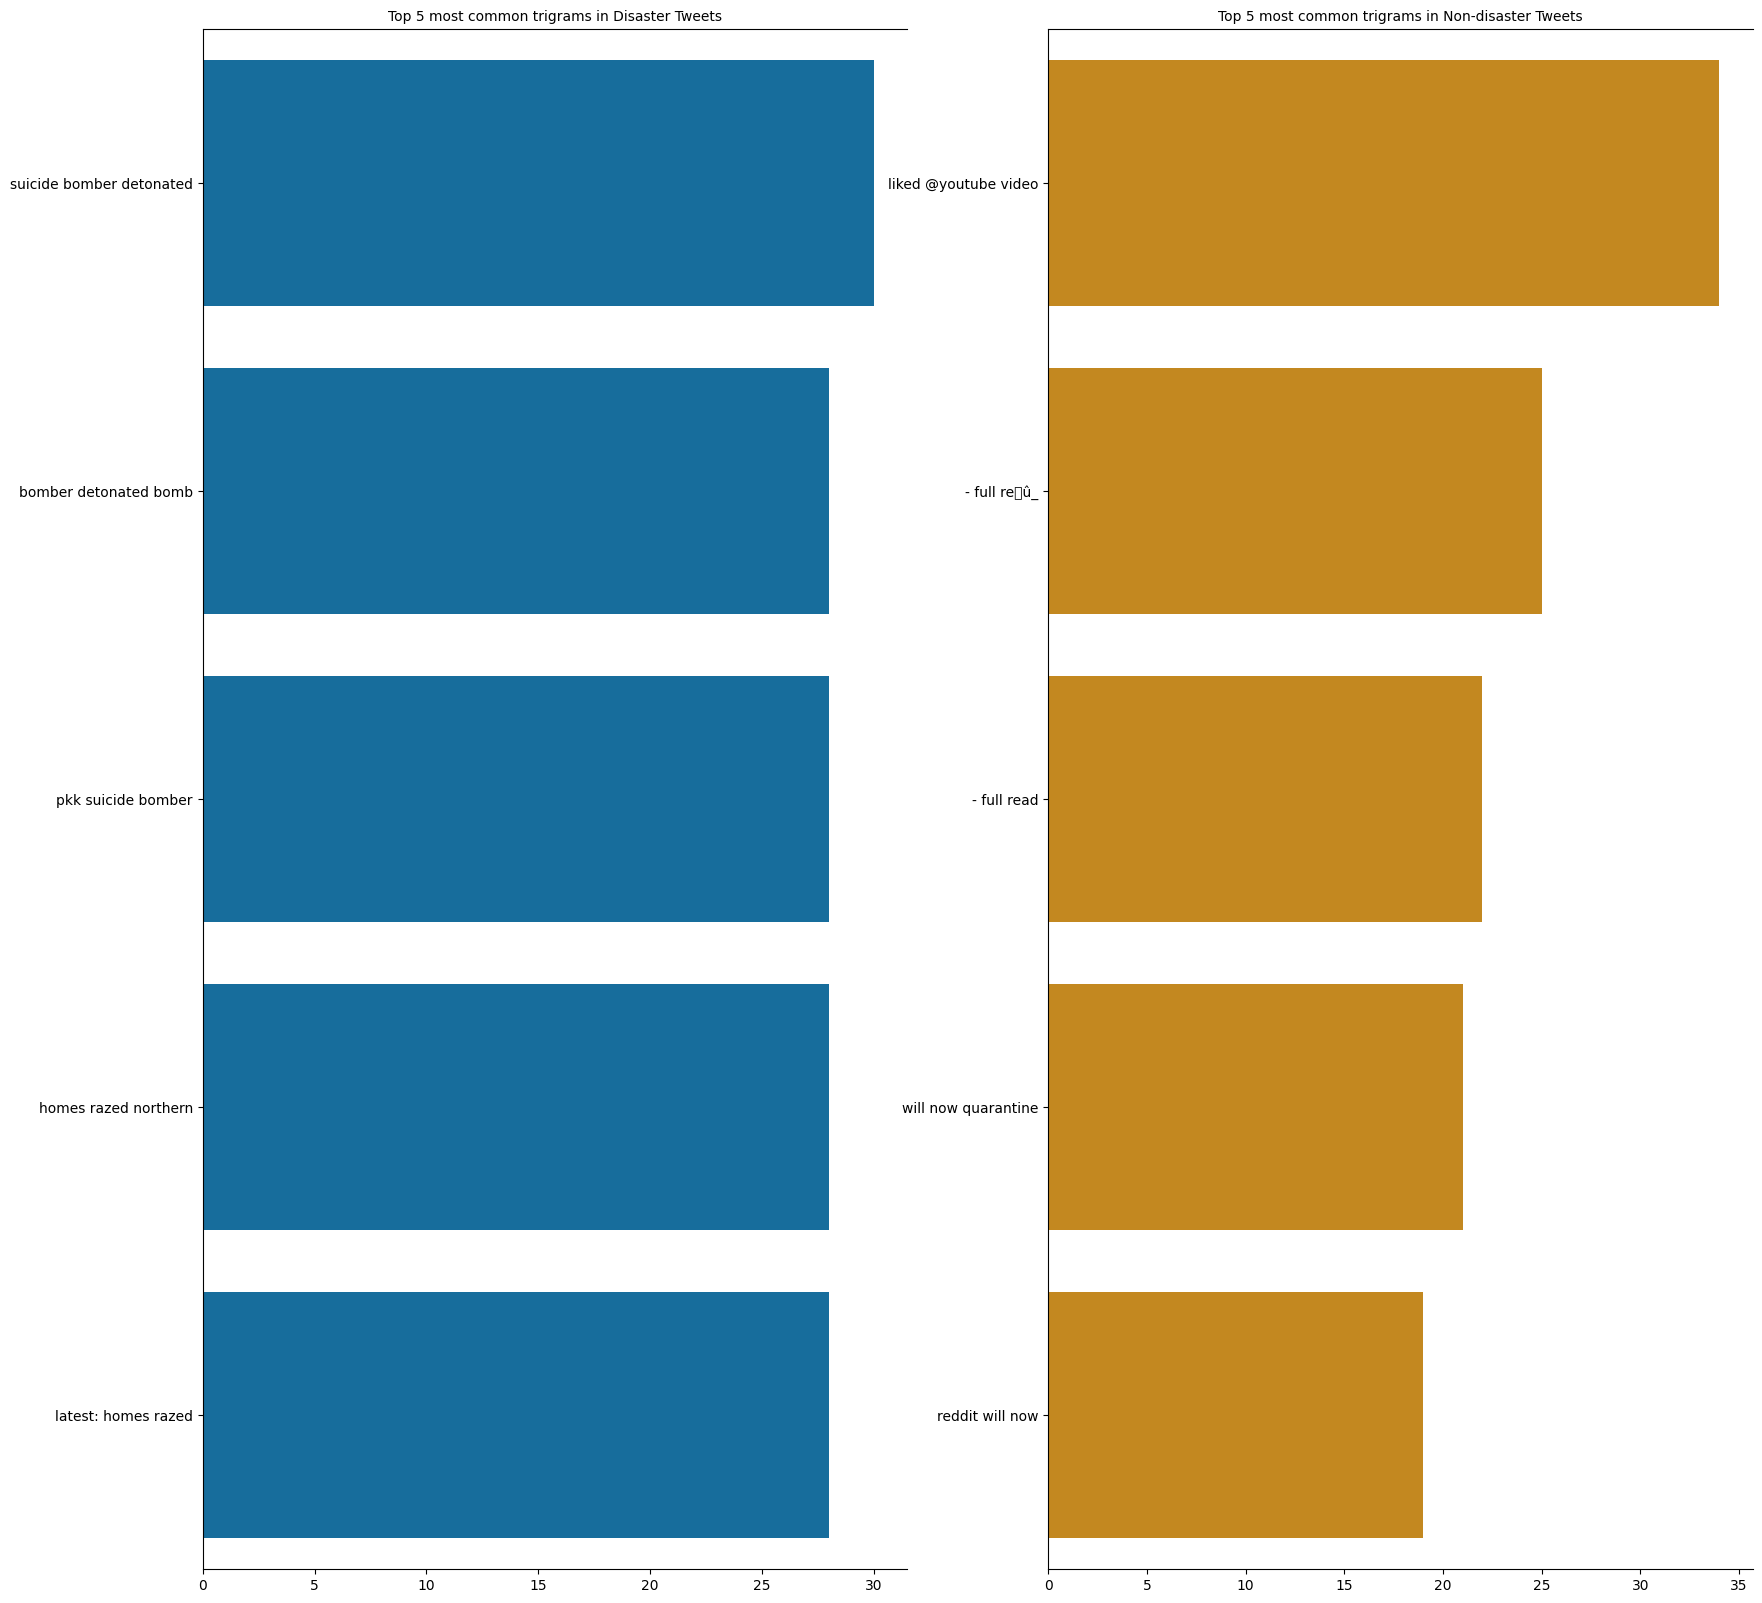

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 20), dpi=100)

sns.barplot(y=df_disaster_tri[0].values[:num_ngrams], x=df_disaster_tri[1].values[:num_ngrams], ax=axes[0], color=palette[0])
sns.barplot(y=df_non_disaster_tri[0].values[:num_ngrams], x=df_non_disaster_tri[1].values[:num_ngrams], ax=axes[1], color=palette[1])

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)

axes[0].set_title(f'Top {num_ngrams} most common trigrams in Disaster Tweets', fontsize=10)
axes[1].set_title(f'Top {num_ngrams} most common trigrams in Non-disaster Tweets', fontsize=10)
plt.show()

# EDA Insights
1. Tweet Length Insights
Character Length: Most tweets are around 100-150 characters, peaking near the old Twitter limit. Max: 157 characters.
Word Length: Most tweets are between 10-20 words. Max: 31 words.

2. Target Distribution
 - 0 (non-disaster): 4342, 1 (disaster): 3271
 - Slight imbalance, but nothing extreme. I could consider using class weights or stratifying by target in my train/val splits to make sure the model doesn’t favor the majority class.

3. Keyword Relevance
 - Number of Unique Keywords: 221
 - Highly Disaster-Related Keywords: derailment, wreckage, debris, outbreak, etc., all have ~100% disaster association.
 - Keywords are strong indicators of disaster tweets.
 - I could include keywords as categorical features (one-hot encoding or embedding) or combine keywords with tweet text with concatenation.

4. Location Relevance
 - Number of Unique Locations: 3341
 - Locations like Mumbai, India, Nigeria have a high disaster ratio.
 - But many locations have sparse data or are missing (33% missing in the training set).
 - Location might not be as predictive unless cleaned and standardized.
 - I could use location only if its not missing or I could drop the feature if it doesn’t improve model performance.

5. Tweet Length vs. Disaster Classification
 - Boxplot Insights: Disaster tweets don’t seem much longer or shorter than non-disaster ones.
 - Length might not be a strong predictor on its own, but can still be included as an extra feature.

6. Ngrams
- Unigrams show fire as a positive indcator and full as negative, although there is a lot of noise from the uncleaned text.
- Bigrams show suicide bomber and northern california as positive correlated, while full read is not.
- Trigrams show suicide bomber detonated as the most common positive trigram and  liked @youtube video as most common non disaster trigram. 


# Data Cleaning

First, I want to copy my orginal dataframes to have a reference to call back to if I need a copy of the untouched data. 

In [ ]:
# original data untouched
df_train_original = df_train.copy()
df_test_original = df_test.copy()

# copy for TF-IDF baseline
df_tfidf_train = df_train_original
df_tfidf_test = df_test_original

Here, I look for duplicate tweets that could possibly contain differing target values. Then, I relabel the incorrectly labeled tweets to contain the proper target so my model does not accidentally learn something as a disaster when it truly is not. Humans can make mistakes too afterall ;)

In [ ]:
# group by unique tweets, count number of unique values for each group, return texts with dif labels 
df_mislabeled_tfidf = df_tfidf_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled_tfidf = df_mislabeled_tfidf[df_mislabeled_tfidf['target'] > 1]['target']
df_mislabeled_tfidf.index.tolist()

['Caution: breathing may be hazardous to your health.',
 'wowo--=== 12000 Nigerian refugees repatriated from Cameroon',
 'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'To fight bioterrorism sir.',
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG',
 'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife',
 "Mmmmmm I'm burning...

In [ ]:
# handling mislabeled Data
df_tfidf_train['target_relabeled'] = df_tfidf_train['target'].copy()

# correcting mislabeled tweets
df_tfidf_train.loc[df_tfidf_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "To fight bioterrorism sir.", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "Hellfire is surrounded by desires so be careful and don’t let your desires control you! #Afterlife", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring", 'target_relabeled'] = 1
df_tfidf_train.loc[df_tfidf_train['text'] == "Hellfire! We don’t even want to think about it or mention it so let’s not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == ".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4", 'target_relabeled'] = 1
df_tfidf_train.loc[df_tfidf_train['text'] == "Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE", 'target_relabeled'] = 1
df_tfidf_train.loc[df_tfidf_train['text'] == "that horrible sinking feeling when you’ve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit", 'target_relabeled'] = 0
df_tfidf_train.loc[df_tfidf_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0

Next, I perform extensive text cleaning by removing special characters, contractions, character entity references, hashtags, usernames, and URLs. I normalize elipses such that '..' and '...' become ' ... '. Additionally, I group the same words without embeddings, perform lowercasing, and stopword removal.

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# regex patterns for efficiency
special_chars = re.compile(r"[\x89Û_ÒÓÏ\x89Û÷ÛªÛ\x9då_åÈå¨åÇå£åÀÌ©]")
HTML_encoded = re.compile(r"&gt;|&lt;|&amp;")
username_pattern = re.compile(r"@(\w+)")
hashtags_pattern = re.compile(r"#\w+")
url_prefix = re.compile(r"https?://\S+|www\.\S+")
punctuation = re.compile(r"[@#!?+&*[\]%.:/();$=><|{}^'`]")
ellipsis_norm = re.compile(r"\.\.\.")

# get disaster-related keywords outside the function for efficiency
disaster_keywords = set(df_disaster_uni[0].tolist()[:num_ngrams] + df_disaster_bi[0].tolist()[:num_ngrams] + df_disaster_tri[0].tolist()[:num_ngrams])

def clean(text):
    if not isinstance(text, str):
        return text # skip non-strings
    
    text = special_chars.sub("", text) # remove special characters
    text = contractions.fix(text) # expand contractions
    text = HTML_encoded.sub(lambda match: {"&gt;": ">", "&lt;": "<", "&amp;": "&"}[match.group(0)], text) # replace HTML refernces 
    
    username_pattern = username_pattern.findall(text) # usernames
    text = username_pattern.sub(lambda match: match.group(1) if "news" in match.group(1).lower() else "", text)

    # handle hashtags
    hashtags = hashtags_pattern.findall(text)   
    relevant_hashtags = [ht for ht in hashtags if any(word in ht.lower() for word in disaster_keywords)]
    text = hashtags_pattern.sub("", text)
    if relevant_hashtags:
        text += " " + " ".join(relevant_hashtags)

    text = url_prefix.sub("", text) # remove URLs
    text = punctuation.sub(lambda match: f" {match.group(0)} ", text) # add spaces around punctuation
    text = ellipsis_norm.sub(" ... ", text) # normalize ellipsis
    text = text.lower() # lowercasing
    text = text.translate(str.maketrans("", "", string.punctuation)) # remove punctuation
    text = " ".join(word for word in text.split() if word not in stop_words) # remove stopwords

    return text.strip()

# apply cleaning
df_tfidf_train["cleaned_text"] = df_tfidf_train["text"].apply(clean)
df_tfidf_test["cleaned_text"] = df_tfidf_test["text"].apply(clean)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Baseline Models 
Here, I decided to perform simple TF-IDF, which is Term Frequency-Inverse Document Frequency. I decided to use this because it's a straightforward yet effective method for converting text into numerical features. This will be sufficient for baseline model comparison. I will use the TF-IDF cleaned text outputs to use in my baseline logistic regression, CatBoost, and SVM models to get a sense of performance. I will plot confusion matrices for each as well as classification reports to see the accuracy, precision, recall, and f1 scores.

In [ ]:
# TF-IDF on entire training set
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf_full = tfidf_vectorizer.fit_transform(df_tfidf_train['cleaned_text'])
y_full = df_tfidf_train['target_relabeled']
# split for local val
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_tfidf_full, y_full, test_size=0.2, random_state=42)

In [ ]:
def evaluate_and_display(model_name, y_true, y_pred):
    """Function to print accuracy, precision, recall, and f1 scores and display confusion matrix for each model"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"\n{model_name}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot()
    plt.show()
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred))


Local Logistic Regression
Accuracy:  0.7991
Precision: 0.8135
Recall:    0.6857
F1 Score:  0.7441


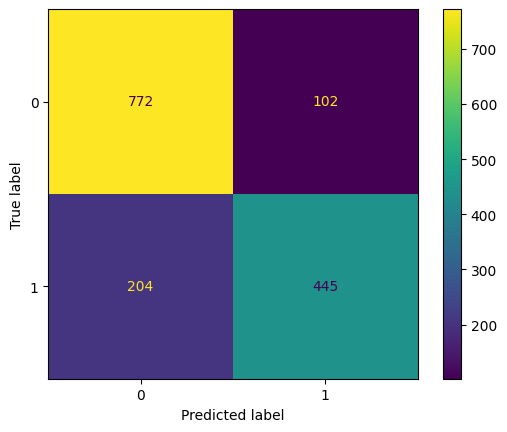

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.81      0.69      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523


Local CatBoost
Accuracy:  0.7833
Precision: 0.8275
Recall:    0.6210
F1 Score:  0.7095


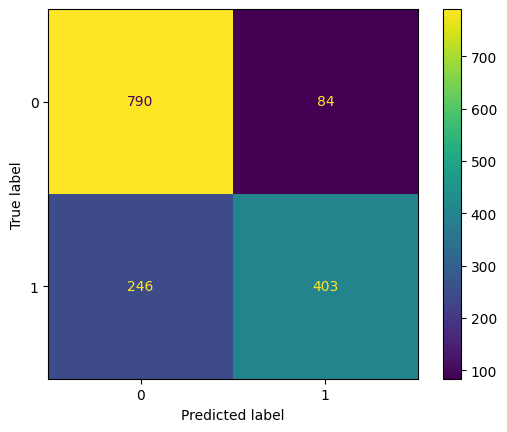

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.83       874
           1       0.83      0.62      0.71       649

    accuracy                           0.78      1523
   macro avg       0.80      0.76      0.77      1523
weighted avg       0.79      0.78      0.78      1523


Local SVM
Accuracy:  0.8056
Precision: 0.8336
Recall:    0.6795
F1 Score:  0.7487


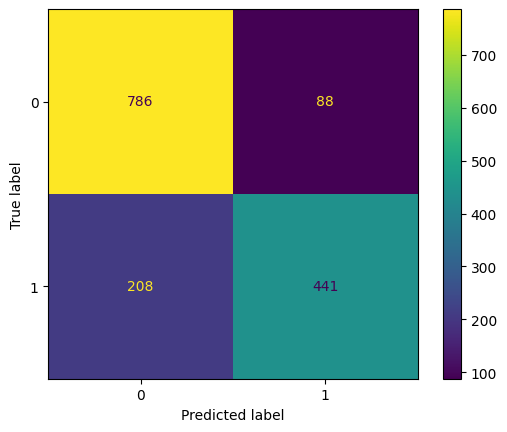

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.68      0.75       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



In [ ]:
# local logistic regression
lr_local = LogisticRegression()
lr_local.fit(X_train_split, y_train_split)
y_pred_lr = lr_local.predict(X_val_split)

evaluate_and_display("Local Logistic Regression", y_val_split, y_pred_lr)

# local CatBoost
cb_local = CatBoostClassifier(verbose=0, random_state=42)
cb_local.fit(X_train_split, y_train_split)
y_pred_cb = cb_local.predict(X_val_split)

evaluate_and_display("Local CatBoost", y_val_split, y_pred_cb)

# local SVM
svm_local = SVC(random_state=42)
svm_local.fit(X_train_split, y_train_split)
y_pred_svm = svm_local.predict(X_val_split)

evaluate_and_display("Local SVM", y_val_split, y_pred_svm)

In [ ]:
# final log reg 
lr_final = LogisticRegression()
lr_final.fit(X_tfidf_full, y_full)

# final CatBoost
cb_final = CatBoostClassifier(verbose=0, random_state=42)
cb_final.fit(X_tfidf_full, y_full)

# final SVM
svm_final = SVC(probability=True, random_state=42)
svm_final.fit(X_tfidf_full, y_full)

SVC(probability=True, random_state=42)

In [ ]:
X_test_tfidf = tfidf_vectorizer.transform(df_tfidf_test['cleaned_text'])

# log reg on test set
lr_test_preds = lr_final.predict(X_test_tfidf)
pd.DataFrame({"id": df_test["id"], "target": lr_test_preds}).to_csv("logreg_submission.csv", index=False)
print("Logistic Regression Submission Saved")

# CatBoost on test set 
cb_test_preds = cb_final.predict(X_test_tfidf)
pd.DataFrame({"id": df_test["id"], "target": cb_test_preds}).to_csv("catboost_submission.csv", index=False)
print("CatBoost Submission Saved")

# SVM on test set 
svm_test_preds = svm_final.predict(X_test_tfidf)
pd.DataFrame({"id": df_test["id"], "target": svm_test_preds}).to_csv("svm_submission.csv", index=False)
print("SVM Submission Saved")

Logistic Regression Submission Saved
CatBoost Submission Saved
SVM Submission Saved


### Baseline Model Results
| Model                       | Accuracy | Precision | Recall | F1 Score | Kaggle Submission Score |
|-----------------------------|----------|-----------|--------|----------|-------------------------|
| Logistic Regression (TF-IDF) | 0.7991   | 0.8135    | 0.6857 | 0.7441   | 0.76144                 |
| CatBoost (TF-IDF)           | 0.7833   | 0.8275    | 0.6210 | 0.7095   | 0.74395                 |
| SVM (TF-IDF)                | 0.8056   | 0.8336    | 0.6795 | 0.7487   | 0.75388                 |


# Model Development and Strategy
For this project, I needed to create a sequentiall neural network, so I chose to use a Gated Recurrent Unit (GRU) based model. These models process sequential data using gates to control the flow of information. These gates can decide whether to remember or forget inputs. This can be quite useful for this project scope because a GRU model will excel at capturing long range dependencies in tweets. These long range dpenendcies help in understanding the context. For example, this model can look at the sequence of words to find patterns that indicate a disaster, like specific keywords for example. Then if it finds a pattern that it thinks is predictive it will retain that information. 

To further explore model performance, a DeBERTa Transformer-based architecture was also implemented. DeBERTa, an enhanced masked language model, uses advanced masking strategies and disentangled attention to better understand nuanced text. This model generates CLS embeddings, capturing the overall meaning of tweets. Optuna hyperparameter optimization was used to fine-tune DeBERTa's performance.

### Data Cleaning and Preprocessing for GRU Model

In [ ]:
# copy for TF-IDF baseline
df_gru_train = df_train_original
df_gru_test = df_test_original
# group by unique tweets, count number of unique values for each group, return texts with dif labels 
df_mislabeled_gru = df_gru_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled_gru = df_mislabeled_gru[df_mislabeled_gru['target'] > 1]['target']
df_mislabeled_gru.index.tolist()

['Caution: breathing may be hazardous to your health.',
 'wowo--=== 12000 Nigerian refugees repatriated from Cameroon',
 'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'To fight bioterrorism sir.',
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG',
 'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife',
 "Mmmmmm I'm burning...

In [ ]:
# handling mislabeled Data
df_gru_train['target_relabeled'] = df_gru_train['target'].copy()

# correcting mislabeled tweets
df_gru_train.loc[df_gru_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "To fight bioterrorism sir.", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "Hellfire is surrounded by desires so be careful and don’t let your desires control you! #Afterlife", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring", 'target_relabeled'] = 1
df_gru_train.loc[df_gru_train['text'] == "Hellfire! We don’t even want to think about it or mention it so let’s not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == ".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4", 'target_relabeled'] = 1
df_gru_train.loc[df_gru_train['text'] == "Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE", 'target_relabeled'] = 1
df_gru_train.loc[df_gru_train['text'] == "that horrible sinking feeling when you’ve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit", 'target_relabeled'] = 0
df_gru_train.loc[df_gru_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0

Here, I remove special characters, URLs, usernames, and hashtags. I keep word order in tact which is essential for RNN based models. I apply lowercasing and remove noise by normalizinf punctuation, ellipses, and removing stopwords. 

In [ ]:
# regex patterns
special_chars = re.compile(r"[\x89Û_ÒÓÏ÷ª\x9dåÊÈ¨ÇÀ]") # removes meaningless Unicode artifacts
HTML_encoded = re.compile(r"&gt;|&lt;|&amp;")# encoded HTML like &gt; (>), &lt; (<), &amp; &
usernames_pattern = re.compile(r"@(\w+)") # twitter usernames (@user)
hashtags_pattern = re.compile(r"#\w+") # hashtags 
url_prefix = re.compile(r"https?://\S+|www\.\S+") # URLs (HTTP/HTTPS and www.)
punctuation = re.compile(r"[@#!?+&*[\]%.:/();$=><|{}^'`]") # common punctuation
ellipsis_norm = re.compile(r"\.\.\.") # ellipsis ("...")

# dict for word replacements
word_replacements = {"China\x89Ûªs": "China's", "let\x89Ûªs": "let's", "JapÌ_n": "Japan", "Ì©": "e", "SuruÌ¤": "Suruc", "å£3million": "3 million", "don\x89Ûªt": "don't", "it\x89Ûªs": "it's",
                     "doesn\x89Ûªt": "doesn't", "I\x89Ûªm": "I'm", "you\x89Ûªre": "you're", "you\x89Ûªll": "you'll", "Let\x89Ûªs": "Let's", "recentlu": "recently", "Ph0tos": "Photos", "exp0sed": "exposed",
                     "amageddon": "armageddon", "Trfc": "Traffic", "TRAUMATISED": "traumatized", "WindStorm": "Wind Storm", "8/5/2015": "2015-08-05", "8/6/2015": "2015-08-06",
                     "10:38PM": "10:38 PM", "10:30pm": "10:30 PM", "16yr": "16 year", "<3": "love"}

def clean_gru(text):
    if not isinstance(text, str):
        return text  # skip non strings

    text = special_chars.sub("", text) # remove special characters

    for key, value in word_replacements.items(): # expand contractions
        text = text.replace(key, value)

    
    text = HTML_encoded.sub(lambda match: {"&gt;": ">", "&lt;": "<", "&amp;": "&"}[match.group(0)], text) # replace encoded HTML
    text = usernames_pattern.sub("", text) # remove usernames 
    text = hashtags_pattern.sub("", text) # remove hashtags
    text = url_prefix.sub("", text) # remove URLs
    text = punctuation.sub(lambda match: f" {match.group(0)} ", text) # normalize punctuation
    text = ellipsis_norm.sub(" ... ", text) # normalize ellipsis
    text = text.lower()  # convert to lowercase (for embeddings)
    text = " ".join(word for word in text.split() if word not in stop_words) # remove stopwords

    return text.strip()

In [ ]:
df_gru_train["cleaned_text"] = df_gru_train["text"].apply(clean_gru)
df_gru_test["cleaned_text"] = df_gru_test["text"].apply(clean_gru)

In [ ]:
max_len_cleaned_gru_test = df_gru_test['cleaned_text'].str.len().max()
print(max_len_cleaned_gru_test)
max_len_text_gru_test = df_gru_test['text'].str.len().max()
print(max_len_text_gru_test)

max_len_cleaned_gru_train = df_gru_train['cleaned_text'].str.len().max()
print(max_len_cleaned_gru_train)
max_len_text_gru_train = df_gru_train['text'].str.len().max()
print(max_len_text_gru_train)

133
151
165
157


## GRU Model Architecture Overview

This model uses a Gated Recurrent Unit (GRU) network for binary text classification. The architecture is designed to capture sequential dependencies within tweets, using pre-trained GloVe embeddings for word representations.

**Components:**

* **Word-Level Tokenization:** The input text is tokenized at the word level, creating a vocabulary from the training data. This method is simple and effective at capturing semantic meaning in short texts.
* **GloVe Embeddings:** Pre-trained GloVe embeddings are used to initialize the embedding layer, providing word representations. 
* **Bidirectional GRU Layers:** The model uses bidirectional GRU layers to capture past and future contextual information within the tweets. Multiple GRU layers allow for modeling deeper dependencies.
* **Attention Mechanism:** A simple attention mechanism is included to allow the model to focus on the most relevant words in the tweet.
* **Fully Connected Output Layer:** A fully connected layer with a sigmoid activation function produces the final binary classification output.
* **Hyperparameter Tuning:** Optuna is used to optimize key hyperparameters, including GRU hidden size, number of layers, dropout rate, and learning rate.

**Development Strategy/Rationale:**

* Word-level tokenization is good for capturing the semantic meaning of individual words, which is important in disaster tweets.
* GloVe embeddings provide a strong foundation for word representations, especially for common words.
* Bidirectional GRUs are effective in understanding context from both directions in a sequence.
* The attention mechanism helps the model focus on the most important words.
* Optuna tuning is used to find the best model configuration.

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# init tokenizer
tokenizer = Tokenizer(WordLevel(unk_token="<UNK>")) #  word level tokenizer, <UNK> is the token for unknown words
tokenizer.pre_tokenizer = Whitespace() # splits text into words based on whitespace

# prep data 
train_texts = df_gru_train["cleaned_text"].tolist()
test_texts = df_gru_test["cleaned_text"].tolist()

# train vocab 
trainer = WordLevelTrainer(special_tokens=["<PAD>", "<UNK>"], min_frequency=2) # WordLevelTrainer trains the tokenizer's vocab
# <PAD> is for padding sequences to the same length
# words appearing less than 2 times in training data are not included in the vocab
tokenizer.train_from_iterator(train_texts, trainer)

# get token IDs
pad_token_id = tokenizer.token_to_id("<PAD>") # numerical ID for the padding token
unk_token_id = tokenizer.token_to_id("<UNK>") # numerical ID for the unknown token.
vocab_size = tokenizer.get_vocab_size()
print(f"Vocabulary size: {vocab_size}")

# define dataset class w proper handling
class TweetDataset(TorchDataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=50):
        self.texts = [tokenizer.encode(text).ids[:max_length] for text in texts]
        self.has_labels = labels is not None

        if self.has_labels:
            # convert labels to float Tensor
            self.labels = torch.tensor(np.array(labels), dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # idx is an integer, not a list
        text_tensor = torch.tensor(self.texts[idx], dtype=torch.long)

        if self.has_labels:
            return text_tensor, self.labels[idx]
        return text_tensor

df_gru_train_split, df_gru_val = train_test_split(df_gru_train, test_size=0.2, random_state=42, stratify=df_gru_train["target_relabeled"])
train_dataset = TweetDataset(df_gru_train_split["cleaned_text"], df_gru_train_split["target_relabeled"], tokenizer, max_length=max_len_cleaned_gru_train)
val_dataset = TweetDataset(df_gru_val["cleaned_text"], df_gru_val["target_relabeled"], tokenizer, max_length=max_len_cleaned_gru_train)

# collate function for batches w labels
def train_collate_fn(batch):  # batch is list of tuples, each tuple contains (text_tensor, label)
    texts = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.float32)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=pad_token_id) # pad sequences to same len w/in the batch
    return texts_padded, labels

# collate function for test batches (no labels)
def test_collate_fn(batch):
    texts = batch if isinstance(batch[0], torch.Tensor) else batch
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=pad_token_id)
    return texts_padded

Using device: cuda
Vocabulary size: 6084


In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout, bidirectional, glove_embeddings=None, pad_token_id=0):
        super(GRUClassifier, self).__init__()
        
        # embedding layer
        if glove_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(glove_embeddings, freeze=False, padding_idx=pad_token_id)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_token_id)
        
        # add embedding dropout
        self.embedding_dropout = nn.Dropout(dropout * 0.8) # 20% lower than main dropout
        
        # GRU layers
        self.gru = nn.GRU(input_size=embedding_dim, 
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0,
                          bidirectional=bidirectional,
                          batch_first=True)
        
        # simple attention mechanism
        gru_output_size = hidden_size * 2 if bidirectional else hidden_size
        self.attention = nn.Linear(gru_output_size, 1)
        
        # output layer
        self.fc = nn.Linear(gru_output_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, output_logits=False):
        # apply embedding w dropout
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        
        gru_out, _ = self.gru(embedded) # get GRU outputs
        attention_weights = torch.softmax(self.attention(gru_out), dim=1) # apply attention
        context_vector = torch.sum(attention_weights * gru_out, dim=1)
        context_vector = self.dropout(context_vector) # apply dropout
        logits = self.fc(context_vector) # pass through final linear layer
        
        # get logits if requested
        if output_logits:
            return logits.squeeze()
        
        # otherwise return sigmoid probabilities
        return self.sigmoid(logits).squeeze()

In [ ]:
# create preprocessing function for GloVe embeddings
def create_embedding_matrix(tokenizer, glove_model, embedding_dim=50):
    vocab_dict = tokenizer.get_vocab()
    vocab_size = len(vocab_dict)
    
    # init w random for OOV tokens
    embedding_matrix = np.random.randn(vocab_size, embedding_dim).astype(np.float32) * 0.  # sets all the elts of embedding_matrix to zero
    glove_vocab = set(glove_model.key_to_index) # change to set for fast lookup
    words_found = 0  # count words found in GloVe
    
    # fill w GloVe vectors when available
    for token, index in vocab_dict.items():
        if token in glove_vocab:
            embedding_matrix[index] = glove_model[token]
            words_found += 1
    
    print(f"Found embeddings for {words_found}/{vocab_size} words ({words_found/vocab_size:.1%})")
    return torch.tensor(embedding_matrix, dtype=torch.float32)

In [ ]:
# training loop w class weight handling
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=4, patience=1):
    best_f1 = 0
    best_model_state = None
    patience_counter = 0
    
    # training history
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    
    for epoch in range(num_epochs):
        # training phase
        model.train()
        total_loss = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() # zero gradients
            outputs = model(inputs, output_logits=isinstance(criterion, nn.BCEWithLogitsLoss)) # fwd pass to get logits for BCEWithLogitsLoss
            loss = criterion(outputs, labels) # calc loss
            loss.backward() # bwd pass
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # gradient clipping to prevent exploding gradients
            optimizer.step() # update weights
            total_loss += loss.item() # track loss
            
            # print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} | Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f}")
        
        # calc avg training loss
        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # val phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # get model outputs and calc val loss
                outputs = model(inputs, output_logits=isinstance(criterion, nn.BCEWithLogitsLoss))
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # get preds based on whether we're using logits or probabilities
                if isinstance(criterion, nn.BCEWithLogitsLoss):
                    preds = torch.sigmoid(outputs) > 0.5
                else:
                    preds = outputs > 0.5
                
                # keep predictions and labels
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # calc metrics
        avg_val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(all_labels, all_preds)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(val_f1)
        
        # step the LR scheduler if provided
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()
        
        # print epoch metrics
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {val_f1:.4f}")
        
        # check for improvement
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"New best model with F1: {best_f1:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs. Best F1: {best_f1:.4f}")
            
            # early stopping
            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break
    
    # load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # plot train/val loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # plot val F1
    plt.subplot(1, 2, 2)
    plt.plot(history['val_f1'], label='Validation F1')
    plt.title('F1 Score over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Optuna Hyperparameter Tuning Details

Optuna was uses to optimize the GRU hyperparameters to maximize the F1-score on the validation set. 

* **hidden_size (64 to 512):** This range allows exploration of varying GRU unit capacities. Smaller sizes reduce model complexity and larger sizes allow richer feature representations.
* **num_layers (1 to 4):** The number of layers controls the model's depth. More layers can capture complex dependencies but risk overfitting.
* **dropout (0.2 to 0.6):** Dropout prevents overfitting.
* **learning_rate (1e-5 to 1e-2, log scale):** The learning rate significantly impacts convergence. 
* **bidirectional (True/False):** A bidirectional GRU allows the model to find context from both preceding and following words, which can be helpful for understanding the overall meaning of a tweet.
* **batch_size (16, 32, 64, 128):** Batch size impacts training stability and speed. 
* **weight_decay (1e-6 to 1e-3, log scale):** L2 regularization (weight decay) helps prevent overfitting by penalizing large weights.
* **use_class_weights (True):** Because of class imbalance, class weights are used to help the model learn the minority class.


In [ ]:
print("Loading GloVe embeddings...")
glove_model = api.load("glove-wiki-gigaword-50")
glove_embeddings = create_embedding_matrix(tokenizer, glove_model)

def objective(trial):
    # clear memory
    gc.collect()
    torch.cuda.empty_cache()
    
    hidden_size = trial.suggest_int("hidden_size", 64, 512)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.2, 0.6)
    bidirectional = trial.suggest_categorical("bidirectional", [True, False])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    use_class_weights = trial.suggest_categorical("use_class_weights", [True])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
   
    model = GRUClassifier(vocab_size=vocab_size, 
                          embedding_dim=50, 
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          dropout=dropout,
                          bidirectional=bidirectional,
                          glove_embeddings=glove_embeddings,
                          pad_token_id=pad_token_id).to(device)
    
    # make dataloaders w the trial's batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=train_collate_fn)
    
    # calc class weights if needed
    if use_class_weights:
        # get class distribution from train set
        class_counts = np.bincount(df_gru_train_split["target_relabeled"].astype(int))
        class_weights = torch.tensor([1.0, class_counts[0] / class_counts[1]], dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    # use AdamW for best results 
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # training loop for Optuna 
    num_epochs = 3
    patience = 1
    
    for epoch in range(num_epochs):
        # training phase
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, output_logits=True)  # Get logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # early stopping check
        if epoch >= patience:
            # val phase
            model.eval()
            all_preds = []
            all_labels = []
            
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs, output_logits=True)
                    preds = (torch.sigmoid(outputs) > 0.5).float()
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            return f1_score(all_labels, all_preds)
    
    # final validation
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, output_logits=True)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return f1_score(all_labels, all_preds)

Loading GloVe embeddings...
[==================================================] 100.0% 66.0/66.0MB downloaded
Found embeddings for 5910/6084 words (97.1%)


In [ ]:
# main execution code
def run_gru_model():
    # check class distribution
    print("Train class distribution:", np.bincount(df_gru_train_split["target_relabeled"].astype(int)))
    print("Val class distribution:", np.bincount(df_gru_val["target_relabeled"].astype(int)))
    
    # make datasets w TweetDataset
    train_dataset = TweetDataset(df_gru_train_split["cleaned_text"], df_gru_train_split["target_relabeled"], tokenizer, max_length=max_len_cleaned_gru_train)
    val_dataset = TweetDataset(df_gru_val["cleaned_text"], df_gru_val["target_relabeled"], tokenizer, max_length=max_len_cleaned_gru_train)
    test_dataset = TweetDataset(df_gru_test["cleaned_text"], None, tokenizer, max_length=max_len_cleaned_gru_test)
    
    print("Starting hyperparameter tuning...")
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100) 
    
    # get best hyperparameters
    best_params = study.best_params
    print("Best hyperparameters:", best_params)
    
    # make dataloaders w best batch size
    train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True, collate_fn=train_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False, collate_fn=train_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False, collate_fn=test_collate_fn)
    
    # initialize best model
    best_model = GRUClassifier(vocab_size=vocab_size,
                               embedding_dim=50,
                               hidden_size=best_params["hidden_size"],
                               num_layers=best_params["num_layers"],
                               dropout=best_params["dropout"],
                               bidirectional=best_params["bidirectional"],
                               glove_embeddings=glove_embeddings,
                               pad_token_id=pad_token_id).to(device)
    
    # loss function w class weights
    if best_params["use_class_weights"]:
        # calc class weights
        class_counts = np.bincount(df_gru_train_split["target_relabeled"].astype(int))
        weight_for_1 = class_counts[0] / class_counts[1]
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight_for_1], device=device))
        print(f"Using weighted loss. Weight for positive class: {weight_for_1:.2f}")
    else:
        criterion = nn.BCEWithLogitsLoss()
        print("Using unweighted loss")
    
    # optimizer and learning rate scheduler
    optimizer = optim.AdamW(best_model.parameters(), lr=best_params["learning_rate"], weight_decay=best_params["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
    
    # train the model
    print("Training final model...")
    best_model, history = train_model(best_model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, num_epochs=4, patience=1)
    
    # eval on val set
    best_model.eval()
    y_val_true, y_val_pred = [], []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs) # get probs
            predictions = (outputs > 0.5).float()
            
            y_val_true.extend(labels.cpu().numpy())
            y_val_pred.extend(predictions.cpu().numpy())
    
    # display eval results
    evaluate_and_display("GRU Model (Validation)", np.array(y_val_true), np.array(y_val_pred))
    
    # make preds on test set
    print("Making predictions on test set...")
    test_pred_probs = []
    
    with torch.no_grad():
        for inputs in test_loader:
            # handle both single tensor and tuple inputs
            if isinstance(inputs, tuple):
                inputs = inputs[0]
            
            inputs = inputs.to(device)
            outputs = best_model(inputs)
            test_pred_probs.extend(outputs.cpu().numpy())
    
    # convert probabilities to labels (0/1)
    test_pred_labels = (np.array(test_pred_probs) > 0.5).astype(int)
    
    # make submission file and save 
    submission = pd.DataFrame({"id": df_gru_test["id"], "target": test_pred_labels}) 
    submission.to_csv("submission_gru.csv", index=False)
    print("Submission saved: submission_gru.csv")

    # plot train hist 
    plot_training_history(history)
    
    return best_model, history

Train class distribution: [3483 2607]
Val class distribution: [871 652]


[I 2025-02-25 20:40:50,702] A new study created in memory with name: no-name-d4872f9f-b04b-4a24-b4a0-0c9a9c9abc15


Starting hyperparameter tuning...


[I 2025-02-25 20:41:02,003] Trial 0 finished with value: 0.7302977232924693 and parameters: {'hidden_size': 405, 'num_layers': 4, 'dropout': 0.3786133554983315, 'bidirectional': True, 'learning_rate': 0.0002846305968779114, 'batch_size': 32, 'use_class_weights': True, 'weight_decay': 3.427167138208082e-06}. Best is trial 0 with value: 0.7302977232924693.
[I 2025-02-25 20:41:04,960] Trial 1 finished with value: 0.7404255319148938 and parameters: {'hidden_size': 466, 'num_layers': 2, 'dropout': 0.3269136220107528, 'bidirectional': False, 'learning_rate': 0.0004616426875213543, 'batch_size': 32, 'use_class_weights': True, 'weight_decay': 5.063459852550239e-06}. Best is trial 1 with value: 0.7404255319148938.
[I 2025-02-25 20:41:13,210] Trial 2 finished with value: 0.4721951219512195 and parameters: {'hidden_size': 491, 'num_layers': 4, 'dropout': 0.23820033788334236, 'bidirectional': False, 'learning_rate': 0.005478987424593761, 'batch_size': 16, 'use_class_weights': True, 'weight_decay':

Best hyperparameters: {'hidden_size': 118, 'num_layers': 1, 'dropout': 0.44461885445603366, 'bidirectional': True, 'learning_rate': 0.002706209767820886, 'batch_size': 32, 'use_class_weights': True, 'weight_decay': 1.6652183754661226e-05}
Using weighted loss. Weight for positive class: 1.34
Training final model...
Epoch 1/4 | Batch 50/191 | Loss: 0.5809
Epoch 1/4 | Batch 100/191 | Loss: 0.5988
Epoch 1/4 | Batch 150/191 | Loss: 0.5534
Epoch 1/4 | Train Loss: 0.5854 | Val Loss: 0.5201 | Val F1: 0.7389
New best model with F1: 0.7389
Epoch 2/4 | Batch 50/191 | Loss: 0.7088
Epoch 2/4 | Batch 100/191 | Loss: 0.4374
Epoch 2/4 | Batch 150/191 | Loss: 0.4122
Epoch 2/4 | Train Loss: 0.5031 | Val Loss: 0.5026 | Val F1: 0.7658
New best model with F1: 0.7658
Epoch 3/4 | Batch 50/191 | Loss: 0.2422
Epoch 3/4 | Batch 100/191 | Loss: 0.4169
Epoch 3/4 | Batch 150/191 | Loss: 0.5122
Epoch 3/4 | Train Loss: 0.4468 | Val Loss: 0.5165 | Val F1: 0.7557
No improvement for 1 epochs. Best F1: 0.7658
Early stop

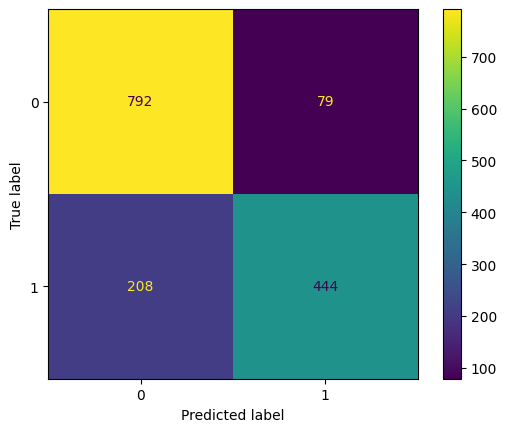

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85       871
         1.0       0.85      0.68      0.76       652

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523

Making predictions on test set...
Submission saved: submission_gru.csv


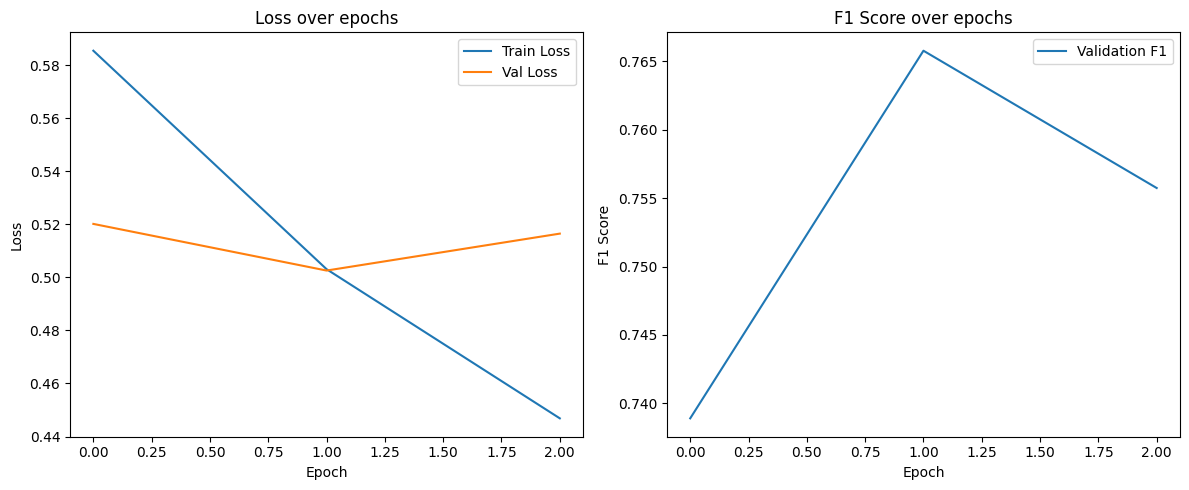

In [45]:
# run the model
if __name__ == "__main__":
    best_model, history = run_gru_model()

## GRU Results Summary
* **Training and Validation Loss:** The training loss decreased consistently over epochs, which suggests effective learning. The validation loss showed a slight fluctuation, indicating potential room for stronger regularization and more optimization.
* **Validation F1-Score:** The F1-score on the validation set peaked at the second epoch, reaching 0.7658.
* **Classification Report:** The model achieved an overall accuracy of 81.16% on the validation set. The precision, recall, and F1-score for class 0 (non-disaster) were higher than for class 1 (disaster), which means the model performed better in identifying non-disaster tweets.
* **Kaggle Submission Score:** Kaggle submission score of 0.79098.

**Best Parameters and Results Table**

| Metric/Parameter       | Value                                 |
| :--------------------- | :------------------------------------ |
| **Best Parameters (Optuna)**                                        
| Hidden Size            | 118                                  |
| Number of Layers       | 1                                    |
| Dropout Rate           | 0.44461885445603366                  |
| Bidirectional          | True                                 |
| Learning Rate          | 0.002706209767820886                 |
| Batch Size             | 32                                   |
| Weight Decay           | 1.6652183754661226e-05               |
| Use Class Weights      | True                                  |
| **Results** |                                       |
| Validation Accuracy    | 0.8116                               |
| Validation F1-Score    | 0.7658                               |
| Kaggle Submission Score| 0.79098                               |
### Data Cleaning and Preprocessing for DeBERTa-Based Models

In [46]:
# new copy for DeBERTa
df_DeBERTa_train = df_train_original.copy()
df_DeBERTa_test = df_test_original.copy()

# fill missing keyword w none 
df_DeBERTa_train['keyword'] = df_DeBERTa_train['keyword'].fillna("none")
df_DeBERTa_test['keyword'] = df_DeBERTa_test['keyword'].fillna("none")

# handling mislabeled data
df_mislabeled_roberta = df_DeBERTa_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled_roberta = df_mislabeled_roberta[df_mislabeled_roberta['target'] > 1]['target']
df_mislabeled_roberta.index.tolist()

['Caution: breathing may be hazardous to your health.',
 'wowo--=== 12000 Nigerian refugees repatriated from Cameroon',
 'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'To fight bioterrorism sir.',
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG',
 'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife',
 "Mmmmmm I'm burning...

In [47]:
# add target relabeled to handle mislabeled data
df_DeBERTa_train['target_relabeled'] = df_DeBERTa_train['target'].copy()

# fixing mislabeled tweets
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "To fight bioterrorism sir.", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "Hellfire is surrounded by desires so be careful and don’t let your desires control you! #Afterlife", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring", 'target_relabeled'] = 1
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "Hellfire! We don’t even want to think about it or mention it so let’s not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == ".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4", 'target_relabeled'] = 1
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE", 'target_relabeled'] = 1
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "that horrible sinking feeling when you’ve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit", 'target_relabeled'] = 0
df_DeBERTa_train.loc[df_DeBERTa_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0

For DeBERTa, less aggressive text cleaning is needed compared to TF-IDF and GRU. DeBERTa excels at understanding context and semantics, so it can handle messier text with spelling errors, slang, and grammatical issues. The cleaning function is simplified to have no lowercasing, stopword removal, contraction expansion, extensive special character removal, hashtag/username/URL removal, or acronym normalization. Only severe typos are corrected, and ellipses are normalized.

In [48]:
usernames_pattern = re.compile(r"@(\w+)")
url_prefix = re.compile(r"https?://[^\s]+|www\.[^\s]+")
unicode_pattern = re.compile(r"[\x89Û_ÒÓÏ÷ª\x9dåÊÈ¨ÇÀ]")  

word_replacements = {"China\x89Ûªs": "China's", "let\x89Ûªs": "let's", "JapÌ_n": "Japan", "Ì©": "e", "SuruÌ¤": "Suruc", "å£3million": "3 million", "don\x89Ûªt": "don't", "it\x89Ûªs": "it's",
                     "doesn\x89Ûªt": "doesn't", "I\x89Ûªm": "I'm", "you\x89Ûªre": "you're", "you\x89Ûªll": "you'll", "Let\x89Ûªs": "Let's", "recentlu": "recently", "Ph0tos": "Photos", "exp0sed": "exposed",
                     "amageddon": "armageddon", "Trfc": "Traffic", "TRAUMATISED": "traumatized", "WindStorm": "Wind Storm", "8/5/2015": "2015-08-05", "8/6/2015": "2015-08-06",
                     "10:38PM": "10:38 PM", "10:30pm": "10:30 PM", "16yr": "16 year", "<3": "love"}

def clean_deberta(text):
    if not isinstance(text, str):
        return text # skip non-strings

    # replace words in a single pass
    for key, value in word_replacements.items():
        text = text.replace(key, value)

    text = unicode_pattern.sub("", text) # remove meaningless artifacts in one step
    text = text.replace("&gt;", ">").replace("&lt;", "<").replace("&amp;", "&") # fix character references
    text = username_pattern.sub(lambda match: match.group(1) if "news" in match.group(1).lower() else "", text) # usernames (vectorized w regex)

    def process_url(match):
        url = match.group(0)
        domain = urlparse(url).netloc.replace("www.", "") # get domain
        return domain if any(ext in domain for ext in [".com", ".gov", ".org", ".edu"]) else ""

    text = url_prefix.sub(process_url, text)
    text = text.replace("...", " ... ").replace("..", " ... ") # normalize ellipses

    return text.strip()

In [49]:
df_DeBERTa_train['cleaned_text'] = df_DeBERTa_train['text'].astype(str).apply(clean_deberta)
df_DeBERTa_test['cleaned_text'] = df_DeBERTa_test['text'].astype(str).apply(clean_deberta)

# concatenate keyword with tweet text
df_DeBERTa_train['cleaned_text'] = df_DeBERTa_train['keyword'] + " " + df_DeBERTa_train['cleaned_text']
df_DeBERTa_test['cleaned_text'] = df_DeBERTa_test['keyword'] + " " + df_DeBERTa_test['cleaned_text']

# fill missing locations with "no location"
df_DeBERTa_train['location'] = df_DeBERTa_train['location'].fillna("no location")
df_DeBERTa_test['location'] = df_DeBERTa_test['location'].fillna("no location")

# concatenate location with cleaned text
df_DeBERTa_train['cleaned_text'] = df_DeBERTa_train['location'] + " " + df_DeBERTa_train['cleaned_text']
df_DeBERTa_test['cleaned_text'] = df_DeBERTa_test['location'] + " " + df_DeBERTa_test['cleaned_text']

In [50]:
max_length_cleaned_test = df_DeBERTa_test['cleaned_text'].str.len().max()
print(max_length_cleaned_test)
max_length_text_test = df_DeBERTa_test['text'].str.len().max()
print(max_length_text_test)

max_length_cleaned_train = df_DeBERTa_train['cleaned_text'].str.len().max()
print(max_length_cleaned_train)
max_length_text_train = df_DeBERTa_train['text'].str.len().max()
print(max_length_text_train)

191
151
188
157


In [51]:
df_DeBERTa_train.head()

,id,keyword,location,text,target,text_length_char,text_length_word,target_relabeled,cleaned_text
0,1,none,no location,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,13,1,no location none Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,4,none,no location,Forest fire near La Ronge Sask. Canada,1,38,7,1,no location none Forest fire near La Ronge Sask. Canada
2,5,none,no location,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,22,1,no location none All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,6,none,no location,"13,000 people receive #wildfires evacuation orders in California",1,65,8,1,"no location none 13,000 people receive #wildfires evacuation orders in California"
4,7,none,no location,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,16,1,no location none Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


In [52]:
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base") 
config = DebertaV2ForSequenceClassification.from_pretrained("microsoft/deberta-v3-base").config

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Model Architecture Specifics

In [53]:
# check tokenizer details
print(tokenizer)

# check model config
print(config)

DebertaV2Tokenizer(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
DebertaV2Config {
  "_attn_implementation_autos

## DeBERTa Baseline Model

Here, I fine tune  a DeBERTa-v3-base model for disaster tweet classification. DeBERTa’s disentangled attention mechanism allows for better text representation, making it good for this task. The input text is preprocessed by cleaning tweets and concatenating keywords and locations, making sure the model captures additional context.

A custom Trainer is used with label smoothing loss, which prevents the model from becoming overly confident by redistributing a small bit of the probability across all classes. This helps to improve generalization. The compute_loss function replaces the default loss with this smoothed loss, so that the model is robust to noisy labels. The data collator dynamically pads tokenized inputs to match the longest sequence in each batch, improving efficiency over a fixed length padding.

Optuna is used to tune the learning rate, batch size, warmup steps, weight decay, and gradient accumulation steps, with ranges selected based on best practices for transformer fine tuning [He et al., 2021](https://arxiv.org/abs/2006.03654). Initially, epochs were treated as a hyperparameter, but since results were about the same across different values, it was fixed at 3 epochs to reduce training time. The number of 20 trials was chosen due to time constraints while still allowing for meaningful optimization.

A free_memory function is included to clear GPU memory between trials, preventing out of memory (OOM) errors when loading large models. Training is performed with mixed precision (FP16) to improve efficiency. The model is evaluated using F1-score and the best model is saved after tuning for inference on unseen tweets.


In [54]:
from datasets import Dataset  
import shutil
import warnings
warnings.filterwarnings("ignore", "Was asked to gather along dimension 0")

# label smoothing loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing):
        super().__init__()
        self.smoothing = smoothing
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        n_classes = logits.size(-1)
        targets_1hot = torch.nn.functional.one_hot(targets, num_classes=n_classes).float()
        smoothed_targets = targets_1hot * (1 - self.smoothing) + (self.smoothing / n_classes)
        return self.criterion(log_probs, smoothed_targets)

# calc metric using torch.argmax instead of numpy.argmax (more precision)
def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids  
    preds = torch.argmax(torch.tensor(logits), dim=-1).cpu().numpy()
    return {"f1": f1_score(labels, preds)}

def objective(trial):
    def free_memory():
        gc.collect()
        torch.cuda.empty_cache()
    
    free_memory()

    gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [1, 2, 4, 8])
    learning_rate = trial.suggest_float('learning_rate', 5e-5, 2e-4, log=True)  
    batch_size = trial.suggest_categorical('batch_size', [8, 16])  
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-1, log=True)
    label_smoothing = trial.suggest_float('label_smoothing', 0.02, 0.05)
    num_epochs = trial.suggest_categorical("num_epochs", [3])

    # train val split (80/20)
    train_texts, val_texts, train_labels, val_labels = train_test_split(df_DeBERTa_train['cleaned_text'], df_DeBERTa_train['target_relabeled'], test_size=0.2, random_state=42, stratify=df_DeBERTa_train['target_relabeled'])

    # tokenize data 
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length_cleaned_train, return_tensors='pt')
    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=max_length_cleaned_train, return_tensors='pt')

    # convert to datasets 
    train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'].tolist(), 'attention_mask': train_encodings['attention_mask'].tolist(), 'labels': train_labels.tolist()}) 
    val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'].tolist(), 'attention_mask': val_encodings['attention_mask'].tolist(), 'labels': val_labels.tolist()})

    # load pretrained HF
    model = DebertaV2ForSequenceClassification.from_pretrained("microsoft/deberta-v3-base").to(device)
    
    # label smoothing loss
    loss_fn = LabelSmoothingLoss(smoothing=label_smoothing)

    # dynamically calc warmup steps based on dataset size 
    total_steps = (len(train_dataset) // batch_size // gradient_accumulation_steps) * num_epochs
    warmup_steps = int(total_steps * 0.1) # 10% warmup

    # training args 
    trial_output_dir = "/kaggle/working/deberta_optuna_trial"
    training_args = TrainingArguments(output_dir=trial_output_dir,  
                                      eval_strategy="epoch",
                                      save_strategy="no",  
                                      load_best_model_at_end=False,  
                                      per_device_train_batch_size=batch_size,  
                                      per_device_eval_batch_size=batch_size, 
                                      gradient_accumulation_steps=gradient_accumulation_steps,
                                      num_train_epochs=num_epochs,
                                      learning_rate=learning_rate,
                                      warmup_steps=warmup_steps, 
                                      weight_decay=weight_decay,
                                      lr_scheduler_type="cosine", # to match pretrained model 
                                      fp16=True,
                                      fp16_full_eval=True,
                                      logging_steps=100,
                                      report_to="none")

    # custom trainer class to label smooth 
    class CustomTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs): 
            labels_ = inputs['labels']
            outputs_ = model(**inputs)
            logits_ = outputs_.logits
            loss_ = loss_fn(logits_, labels_)
            return (loss_, outputs_) if return_outputs else loss_


    # collator for dynamic padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = CustomTrainer(model=model,
                            args=training_args,
                            train_dataset=train_dataset,
                            eval_dataset=val_dataset,
                            data_collator=data_collator,
                            compute_metrics=compute_metrics) 

    # train the model
    trainer.train()
    # eval on val set 
    eval_result = trainer.evaluate()
    return eval_result["eval_f1"]

# run study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_hyperparams = study.best_trial.params

[I 2025-02-25 20:45:59,059] A new study created in memory with name: no-name-cf1f7342-1cd9-46f9-bf48-4004734be048
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.480674,0.788253
1,No log,0.414222,0.809112
2,No log,0.414005,0.811502


[I 2025-02-25 20:51:08,128] Trial 0 finished with value: 0.8124501197126897 and parameters: {'gradient_accumulation_steps': 8, 'learning_rate': 5.7760723259284544e-05, 'batch_size': 16, 'weight_decay': 2.6481711354174458e-05, 'label_smoothing': 0.04683625266784183, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.460185,0.796530
1,No log,0.437234,0.783715
2,No log,0.439568,0.793548


[I 2025-02-25 20:56:15,259] Trial 1 finished with value: 0.7941888619854722 and parameters: {'gradient_accumulation_steps': 8, 'learning_rate': 0.00014050225877707359, 'batch_size': 16, 'weight_decay': 0.05291862069533718, 'label_smoothing': 0.047299381041106606, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.562600,0.550481,0.761146
2,0.486100,0.484862,0.788889
3,0.393300,0.474516,0.777414


[I 2025-02-25 21:04:30,819] Trial 2 finished with value: 0.7784137367130007 and parameters: {'gradient_accumulation_steps': 1, 'learning_rate': 8.023160657789041e-05, 'batch_size': 8, 'weight_decay': 0.08211833779736268, 'label_smoothing': 0.043744452883244564, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.454438,0.801262
2,0.385500,0.462770,0.803906


[I 2025-02-25 21:11:49,360] Trial 3 finished with value: 0.8039056143205858 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 7.83806162674296e-05, 'batch_size': 8, 'weight_decay': 0.03054361131275, 'label_smoothing': 0.03707929194699225, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.457146,0.779043
1,No log,0.444564,0.794724
2,0.479700,0.439730,0.806426


[I 2025-02-25 21:17:06,837] Trial 4 finished with value: 0.8057784911717496 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 0.00011417586092634533, 'batch_size': 16, 'weight_decay': 0.0012913467777795505, 'label_smoothing': 0.028801916320374255, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.428003,0.795820
2,0.372100,0.441751,0.805423


[I 2025-02-25 21:24:24,535] Trial 5 finished with value: 0.8054226475279106 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 7.289811932231667e-05, 'batch_size': 8, 'weight_decay': 1.535397470855713e-05, 'label_smoothing': 0.020259280215834532, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.522719,0.794457
2,0.402700,0.443273,0.806164


[I 2025-02-25 21:31:41,664] Trial 6 finished with value: 0.8061638280616383 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 8.302898171755872e-05, 'batch_size': 8, 'weight_decay': 0.00041338714335776406, 'label_smoothing': 0.03297555860052104, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.592800,0.550939,0.765658
2,0.464600,0.488109,0.758148


[I 2025-02-25 21:39:18,881] Trial 7 finished with value: 0.7581475128644941 and parameters: {'gradient_accumulation_steps': 2, 'learning_rate': 9.66040296880375e-05, 'batch_size': 8, 'weight_decay': 0.0009449338246767491, 'label_smoothing': 0.04923878789717125, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.583800,0.480881,0.795200
2,0.419800,0.455666,0.804781


[I 2025-02-25 21:46:56,035] Trial 8 finished with value: 0.8054226475279106 and parameters: {'gradient_accumulation_steps': 2, 'learning_rate': 7.316283526345804e-05, 'batch_size': 8, 'weight_decay': 1.598924948461295e-06, 'label_smoothing': 0.0424768855531335, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.464123,0.782473
2,0.396700,0.440383,0.803601


[I 2025-02-25 21:54:13,868] Trial 9 finished with value: 0.8036006546644844 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 9.498489915140794e-05, 'batch_size': 8, 'weight_decay': 0.0009380548932162812, 'label_smoothing': 0.03435081098764189, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.447226,0.765517
1,No log,0.433693,0.781648
2,No log,0.428767,0.801988


[I 2025-02-25 21:59:20,623] Trial 10 finished with value: 0.8019884009942004 and parameters: {'gradient_accumulation_steps': 8, 'learning_rate': 5.413743974735961e-05, 'batch_size': 16, 'weight_decay': 4.1740351573719664e-05, 'label_smoothing': 0.04228058585610879, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.438354,0.796530
1,No log,0.412134,0.789518
2,No log,0.429991,0.796342


[I 2025-02-25 22:04:27,711] Trial 11 finished with value: 0.7963424771404821 and parameters: {'gradient_accumulation_steps': 8, 'learning_rate': 5.0668904485007863e-05, 'batch_size': 16, 'weight_decay': 6.258290327938242e-05, 'label_smoothing': 0.028796926325772673, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.582000,0.602002,0.542017
2,0.678000,0.683516,0.000000
3,0.687700,0.683468,0.000000


[I 2025-02-25 22:10:14,198] Trial 12 finished with value: 0.0 and parameters: {'gradient_accumulation_steps': 1, 'learning_rate': 0.00018632594464802646, 'batch_size': 16, 'weight_decay': 4.706637251891253e-06, 'label_smoothing': 0.03353332893141747, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.553321,0.762290
1,No log,0.434134,0.783133
2,No log,0.433196,0.796402


[I 2025-02-25 22:15:21,031] Trial 13 finished with value: 0.7964022894521668 and parameters: {'gradient_accumulation_steps': 8, 'learning_rate': 5.9105018463205185e-05, 'batch_size': 16, 'weight_decay': 0.00014079793331785528, 'label_smoothing': 0.038199263554900074, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.436203,0.798387
2,0.389800,0.441820,0.811336


[I 2025-02-25 22:22:39,038] Trial 14 finished with value: 0.8113360323886639 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 6.124630910904706e-05, 'batch_size': 8, 'weight_decay': 0.004441116308613486, 'label_smoothing': 0.029505720928967267, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.461133,0.790526
1,No log,0.416507,0.778547
2,No log,0.424719,0.804224


[I 2025-02-25 22:27:46,012] Trial 15 finished with value: 0.8042242079610072 and parameters: {'gradient_accumulation_steps': 8, 'learning_rate': 6.391188081803338e-05, 'batch_size': 16, 'weight_decay': 0.012314962480368966, 'label_smoothing': 0.02270556192462755, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.572700,0.560997,0.775775
2,0.415300,0.450339,0.806178
3,0.310900,0.450650,0.801948


[I 2025-02-25 22:33:32,287] Trial 16 finished with value: 0.8019480519480521 and parameters: {'gradient_accumulation_steps': 1, 'learning_rate': 6.442030244092577e-05, 'batch_size': 16, 'weight_decay': 0.006023377231704053, 'label_smoothing': 0.027196246745210553, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.590900,0.573103,0.716636
2,0.516900,0.528995,0.669223


[I 2025-02-25 22:41:10,129] Trial 17 finished with value: 0.6692233940556088 and parameters: {'gradient_accumulation_steps': 2, 'learning_rate': 0.00012364200104080924, 'batch_size': 8, 'weight_decay': 0.0031306199860416076, 'label_smoothing': 0.025345868570347325, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.438007,0.799688
2,0.381400,0.434056,0.804190


[I 2025-02-25 22:48:27,879] Trial 18 finished with value: 0.8041901692183723 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 5.048699049220878e-05, 'batch_size': 8, 'weight_decay': 2.2821582365691587e-05, 'label_smoothing': 0.03138285522311057, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.485424,0.713076
1,No log,0.414819,0.797428
2,No log,0.430553,0.802944


[I 2025-02-25 22:53:34,429] Trial 19 finished with value: 0.802943581357318 and parameters: {'gradient_accumulation_steps': 8, 'learning_rate': 6.171181068975918e-05, 'batch_size': 16, 'weight_decay': 0.00014116999468659656, 'label_smoothing': 0.03863172239545948, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.530904,0.771300
1,No log,0.529261,0.761429
2,0.545900,0.488305,0.764026


[I 2025-02-25 22:58:51,806] Trial 20 finished with value: 0.7640264026402641 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 0.000198270792907484, 'batch_size': 16, 'weight_decay': 9.141141365596105e-06, 'label_smoothing': 0.046729193616820736, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.595824,0.789394
2,0.392100,0.464447,0.805511


[I 2025-02-25 23:06:09,536] Trial 21 finished with value: 0.8055105348460292 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 8.663383115230541e-05, 'batch_size': 8, 'weight_decay': 0.00029742381060244503, 'label_smoothing': 0.0317535095164604, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.459063,0.783113
2,0.396200,0.438253,0.805849


[I 2025-02-25 23:13:27,180] Trial 22 finished with value: 0.8058489033306255 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 7.128087693003986e-05, 'batch_size': 8, 'weight_decay': 0.0003667045311074377, 'label_smoothing': 0.036303405419791025, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.477871,0.790123
2,0.395300,0.433505,0.810024


[I 2025-02-25 23:20:44,739] Trial 23 finished with value: 0.8100242522231204 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 5.672635388836671e-05, 'batch_size': 8, 'weight_decay': 0.0039682524191713905, 'label_smoothing': 0.0310449193354078, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.471260,0.789272
2,0.399800,0.430104,0.812398


[I 2025-02-25 23:28:02,043] Trial 24 finished with value: 0.8123980424143555 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 5.667107394124108e-05, 'batch_size': 8, 'weight_decay': 0.012843898453767197, 'label_smoothing': 0.025234527629963924, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.423954,0.801228
1,No log,0.414786,0.786498
2,0.467000,0.430423,0.804224


[I 2025-02-25 23:35:10,240] Trial 25 finished with value: 0.8042242079610072 and parameters: {'gradient_accumulation_steps': 8, 'learning_rate': 6.589471687378554e-05, 'batch_size': 8, 'weight_decay': 0.016212242407907536, 'label_smoothing': 0.024628640364326045, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.519000,0.429330,0.774648
2,0.386300,0.425036,0.800955
3,0.282800,0.468523,0.805825


[I 2025-02-25 23:43:25,815] Trial 26 finished with value: 0.8067906224737268 and parameters: {'gradient_accumulation_steps': 1, 'learning_rate': 5.5695374438139845e-05, 'batch_size': 8, 'weight_decay': 0.013318009264067456, 'label_smoothing': 0.022197262831204795, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.571400,0.656457,0.758988
2,0.312400,0.468731,0.798387


[I 2025-02-25 23:51:03,045] Trial 27 finished with value: 0.7983870967741936 and parameters: {'gradient_accumulation_steps': 2, 'learning_rate': 5.781774694403618e-05, 'batch_size': 8, 'weight_decay': 0.0024131988179247293, 'label_smoothing': 0.026788535056203575, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.449700,0.793021
1,No log,0.416526,0.802908
2,0.474000,0.437392,0.803543


[I 2025-02-25 23:56:21,202] Trial 28 finished with value: 0.8035426731078905 and parameters: {'gradient_accumulation_steps': 4, 'learning_rate': 6.77502226159106e-05, 'batch_size': 16, 'weight_decay': 1.192991898232875e-06, 'label_smoothing': 0.029343178216092176, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.459840,0.783607
1,No log,0.432462,0.794564
2,No log,0.438352,0.793703


[I 2025-02-26 00:01:28,123] Trial 29 finished with value: 0.7937033968516983 and parameters: {'gradient_accumulation_steps': 8, 'learning_rate': 0.00014236621114758607, 'batch_size': 16, 'weight_decay': 0.03500991431064801, 'label_smoothing': 0.02468791570775894, 'num_epochs': 3}. Best is trial 0 with value: 0.8124501197126897.


In [55]:
# train final model w best parmas
def train_final_model(best_hyperparams):
    gc.collect()
    torch.cuda.empty_cache()

    model = DebertaV2ForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2).to(device)
    
    for param in model.parameters():
        param.requires_grad=True
    # train val split (80/20)
    train_texts, val_texts, train_labels, val_labels = train_test_split(df_DeBERTa_train['cleaned_text'], df_DeBERTa_train['target_relabeled'], test_size=0.2, random_state=42, stratify=df_DeBERTa_train['target_relabeled'])

    # tokenize data 
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length_cleaned_train, return_tensors='pt')
    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=max_length_cleaned_train, return_tensors='pt')

    # Convert to datasets 
    train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'].tolist(), 'attention_mask': train_encodings['attention_mask'].tolist(), 'labels': train_labels.tolist()}) 
    val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'].tolist(), 'attention_mask': val_encodings['attention_mask'].tolist(), 'labels': val_labels.tolist()})

     # dynamically calc warmup steps based on dataset size 
    total_steps = (len(df_DeBERTa_train) // best_hyperparams['batch_size'] // best_hyperparams['gradient_accumulation_steps']) * best_hyperparams['num_epochs']
    warmup_steps = int(total_steps * 0.1) # 10% warmup

    # training args 
    final_training_args = TrainingArguments(output_dir="/kaggle/working/final_deberta_model",  
                                            save_strategy="epoch",
                                            num_train_epochs=best_hyperparams['num_epochs'],
                                            per_device_train_batch_size=best_hyperparams['batch_size'],  
                                            per_device_eval_batch_size=best_hyperparams['batch_size'], 
                                            gradient_accumulation_steps=best_hyperparams['gradient_accumulation_steps'],
                                            learning_rate=best_hyperparams['learning_rate'],
                                            warmup_steps=warmup_steps, 
                                            weight_decay=best_hyperparams['weight_decay'],
                                            lr_scheduler_type="cosine", # to match pretrained model 
                                            fp16=True,
                                            fp16_full_eval=True,
                                            logging_steps=100,
                                            report_to="none")
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainer = Trainer(model=model,
                     args=final_training_args,
                     train_dataset = train_dataset,
                     eval_dataset=val_dataset,
                     data_collator=data_collator,
                     compute_metrics=compute_metrics)
    trainer.train()
    trainer.save_model("kaggle/working/final_deberta_model")
    tokenizer.save_pretrained("kaggle/working/final_deberta_model")
train_final_model(best_hyperparams)
print("DONE!!!")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


DONE!!!


In [ ]:
gc.collect()
torch.cuda.empty_cache()

# load trained model & tokenizer
model_path = "/kaggle/working/kaggle/working/final_deberta_model"
best_model = DebertaV2ForSequenceClassification.from_pretrained(model_path).to(device)
best_tokenizer = DebertaV2Tokenizer.from_pretrained(model_path)

# set model to evaluation mode (disables dropout, gradient updates)
best_model.eval()

# tokenize test set
test_inputs = best_tokenizer(list(df_DeBERTa_test['cleaned_text']), truncation=True, padding=True, max_length=max_length_cleaned_test, return_tensors='pt')

# move inputs to GPU
input_ids = test_inputs["input_ids"].to(device)
attention_mask = test_inputs["attention_mask"].to(device)

# define batch size (prevents OOM issues)
batch_size = 16  # Adjust based on available GPU memory
test_pred_labels = []

# run inference in batches
with torch.no_grad(): # disables gradient tracking
    for i in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[i : i + batch_size]
        batch_attention_mask = attention_mask[i : i + batch_size]

        # run model on GPU
        outputs = best_model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

        # move logits back to CPU before applying argmax
        logits = outputs.logits.cpu()
        batch_preds = torch.argmax(logits, dim=-1).numpy()
        test_pred_labels.extend(batch_preds)

# save predictions
submission = pd.DataFrame({"id": df_DeBERTa_test["id"], "target": test_pred_labels})
submission.to_csv("submission_deberta_final.csv", index=False)


In [73]:
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


# Conclusions

## Model Performance Summary

| Model                         | Validation Accuracy | Validation F1 Score | Kaggle Submission Score |
|--------------------------------|---------------------|----------------------|-------------------------|
| Logistic Regression (TF-IDF)   | 0.7991              | 0.7441               | 0.76144                 |
| CatBoost (TF-IDF)              | 0.7833              | 0.7095               | 0.74395                 |
| SVM (TF-IDF)                   | 0.8056              | 0.7487               | 0.75388                 |
| GRU                            | 0.8116              | 0.7658               | 0.79098                 |
| DeBERTa                        | N/A                 | N/A                  | 0.84033                 |

## Project Summary

This project developed models for disaster tweet classification. The process began with EDA to understand text patterns, class distributions, and feature importance. The insights from EDA informed my preprocessing and model selection strategies.

### Baseline Models
Traditional ML models (Logistic Regression, CatBoost, and SVM) were trained using TF-IDF vectorization as a feature extraction method. These models established a strong benchmark, with SVM and Logistic Regression achieving the highest performance among them. However, CatBoost which is usually robust for tabular data, underperformed slightly in F1 score.

### GRU Model
The focus then shifted to sequential deep learning models, specifically **Gated Recurrent Units (GRUs)**, which are good for processing text sequences. The GRU model was enhanced with:
- Word-level tokenization and GloVe embeddings, providing rich word representations
- Bidirectional GRUs to capture context from both past and future tokens
- Attention for improved focus on important tweet segments
- Hyperparameter tuning with Optuna, leading to performance gains

The **GRU model outperformed traditional models**, showing the effectiveness of capturing sequential dependencies in tweets.

### DeBERTa Transformer
To push performance further, a DeBERTa Transformer model was fine tuned, leveraging contextual embeddings and advanced attention mechanisms. This approach resulted in the **highest Kaggle submission score (0.84033)**, demonstrating the power of transformer-based architectures in text classification.

## Factors Contributing to Performance

### **GRU Model:**
 - Strong Word Representations: Used pre-trained GloVe embeddings for better contextual understanding
 - Bidirectional GRUs & Attention: Captured long range dependencies better than traditional RNNs
 - Hyperparameter Tuning: Optuna helped optimize model performance

### **DeBERTa Model:**
 - Transformer-Based Approach: Good at understanding nuanced language
 - Contextual Embeddings: Captured complex semantic relationships in tweets  
 - Less Aggressive Text Cleaning: Allowed the model to retain more useful context


## Potential Improvements

### **GRU Model:**
 - Experiment with different embedding types (FastText, Word2Vec) 
 - Implement more sophisticated attention mechanisms (multi-head attention) 
 - Use stratified k-fold cross-validation for a more robust evaluation  
 - Incorporate additional features such as tweet length, location, or other metadata

### **Overall:**
 - Ensemble models: Combine GRU and DeBERTa predictions using stacking or CatBoost   
 - Use external data sources: Augment the training data with similar datasets 
 - Deeper EDA: Explore topic modeling or word importance analysis for feature engineering  



# References

Evitan, G. (n.d.). NLP with Disaster Tweets: EDA, Cleaning, and BERT. Kaggle. Retrieved from https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

GeeksforGeeks. (2024, January 3). Pre-trained Word Embedding using GloVe in NLP Models. Retrieved from https://www.geeksforgeeks.org pre-trained-word-embedding-using-glove-in-nlp-models/

He, P., Liu, X., Gao, J., & Chen, W. (2021). DeBERTa: Decoding-enhanced BERT with Disentangled Attention. arXiv. Retrieved from https://arxiv.org/abs/2006.03654

PyTorch. (2024). GRU — Gated Recurrent Unit Documentation. Retrieved from https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

PyTorch. (2024). NLP from Scratch: Classifying Names with a Character-Level RNN. Retrieved from https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial

